**This part of the project includes:**

1. Fitting an initial regression model, conducting statistical analyses of the results, taking a look at the p-values of the various features and perform some feature selection. 
2. Testing for regression assumptions including normality, heteroscedasticity, and independence. 
3. From these tests, we'll then refine and improve the model, not just for performance, but for interpretability as well.
4. Improving and deepening our answers to business problems using built models.

**MODEL FITTING & VALIDATION**
**a.	Model Building Summary Steps:**

i.	Perform Stepwise Selection to select for features with p-value < 0.05

ii.	Build the model using statsmodels with the result from stepwise selection and get r2, adjusted r2

1. Predict yhat
2.	Plot yhat regplot
3. Get intercept
4. Get coefficients

iv.	Test initial model

1.	Recheck multicollinearity with heatmap
2.	Recheck residuals normality with qqplot
3.	Recheck residuals homoscedasticity with regplot
4.	K-fold cross-validation

v.	Validate initial model

1.	Train test split and fit the line
2.	Calculate RMSE: very small difference = not overfitted
3.	Plot model residuals vs prediction with regplot
4.	Calculate accuracy percentage
5.	Bias-variance tradeoff

**b.	Models:**

i.	Model A: All features + location

ii.	Model B: All features with outliers (3 STD away) removed + location

iii.Model C: Polynomial Regression on Model A

iv.	Model D: Log transformed all continuous features (not including target ‘price) + all features 

In [1033]:
#import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pickle

import warnings
warnings.filterwarnings("ignore")

Recall that there are four main assumptions underlying a linear regression model:

1. **Linearity:** With linear models, the target variable is being modeled as a linear combination of the independent variables. As such, there should be a linear relationship between the target variable and the various features being used. 

2. **Normality:** With linear models, the errors (residuals) from the model are assumed to be normally distributed. A good heuristic to initially check for this is to use a Q-Q plot.

3. **Homoscedasticity:** Along with the assumption of normal distribution, error terms should also not be correlated with the target variable or other features within the model. If errors indeed appear to be random and there are no discernible trends, then the errors are said to be homoscedastic. Looking at a simple plot of residuals against the target variable or other feature is generally sufficient to gauge this.

4. **Independence:** Finally, regression models assume that the various independent features feeding into the model are independent. We will investigate multicollinearity. Multicollinearity is when a variable can be predicted with substantial accuracy by a separate set of features. It's unwise to include two features in a regression model that are highly correlated. This mistake will severely impede interpretation as coefficient weights of the model become unstable so it is difficult or impossible to determine which features are most influential.

In [1034]:
#read our dataframe
clean = pd.read_csv('./Data & Figures/clean.csv', index_col = 0)
clean.head()

,price,price_log,sqft_above,sqft_above_log,sqft_lot,sqft_lot_log,sqft_living15,sqft_living15_log,sqft_lot15,age,...,cond_5.0,zip_A,zip_B,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I
15937,268950.0,12.502281,880,6.779922,8100,8.999619,1000,6.907755,8100,72,...,0,0,0,0,0,1,0,0,0,0
20963,399900.0,12.898970,900,6.802395,1005,6.912743,1440,7.272398,1188,4,...,0,0,0,0,0,0,0,1,0,0
7614,339000.0,12.733755,720,6.579251,4128,8.325548,1510,7.319865,4538,73,...,0,1,0,0,0,0,0,0,0,0
3257,380000.0,12.847927,840,6.733402,7372,8.905444,1930,7.565275,5150,76,...,1,1,0,0,0,0,0,0,0,0
16723,365000.0,12.807653,1600,7.377759,4168,8.335192,1190,7.081709,4168,88,...,0,1,0,0,0,0,0,0,0,0


In [1035]:
clean.columns

Index(['price', 'price_log', 'sqft_above', 'sqft_above_log', 'sqft_lot',
       'sqft_lot_log', 'sqft_living15', 'sqft_living15_log', 'sqft_lot15',
       'age', 'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0',
       'reno_1.0', 'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0', 'zip_A',
       'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I'],
      dtype='object')

### Prepare Continuous Data: Feature Scaling

In [1036]:
clean_continuous = clean[['price', 'price_log', 
                          'sqft_above', 'sqft_above_log', 
                          'sqft_lot', 'sqft_lot_log', 
                          'sqft_living15', 'sqft_living15_log', 
                          'sqft_lot15', 
                          'age']]

In [1037]:
# normalize (subract mean and divide by std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

clean_continuous_norm = clean_continuous.apply(normalize)

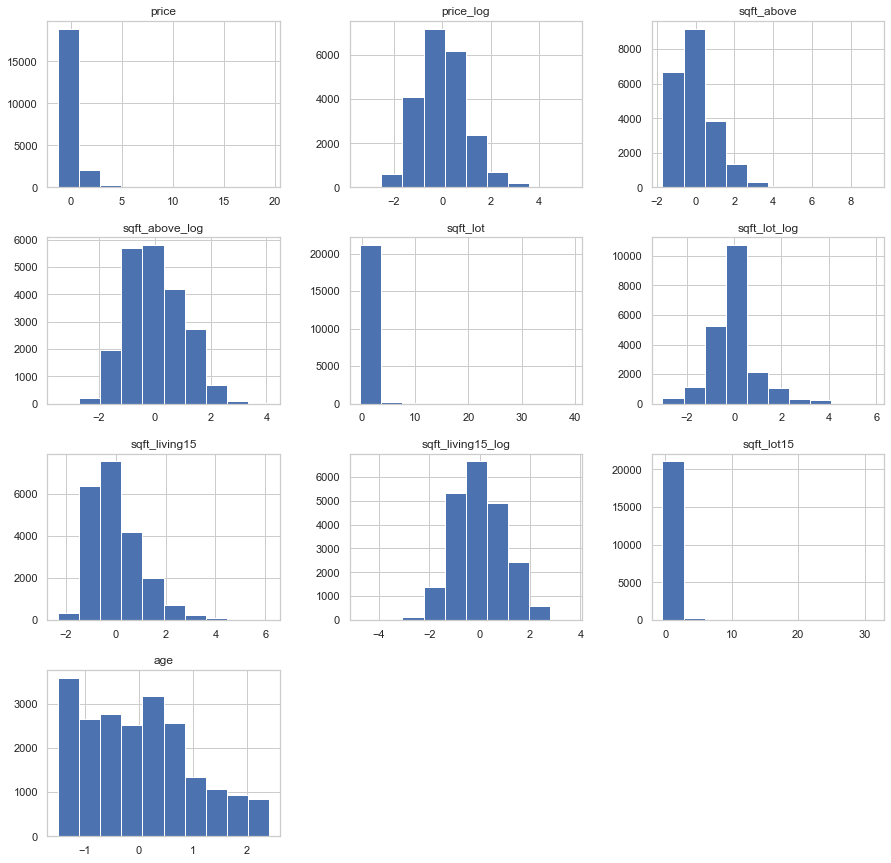

In [1038]:
#plot the new normalized data
clean_continuous_norm.hist(figsize = (15, 15));

#save
plt.savefig('./Data & Figures/log_norm_histplot')

In [1039]:
#drop old values
clean.drop(['price', 'price_log',
            'sqft_above', 'sqft_above_log',
            'sqft_lot', 'sqft_lot_log',
            'sqft_living15', 'sqft_living15_log',
            'sqft_lot15', 'age'], axis = 1, inplace = True)

In [1040]:
#add the newly standardized values
clean = pd.concat([clean, clean_continuous_norm], axis = 1) 

In [1041]:
#review
clean.head()

,bedrooms,bathrooms,floors,water_1.0,base_1.0,reno_1.0,cond_2.0,cond_3.0,cond_4.0,cond_5.0,...,price,price_log,sqft_above,sqft_above_log,sqft_lot,sqft_lot_log,sqft_living15,sqft_living15_log,sqft_lot15,age
15937,3,1.00,1.0,0,1,0,0,1,0,0,...,-0.740571,-1.044412,-1.099527,-1.443346,-0.169225,0.011001,-1.441766,-1.932101,-0.170986,0.955962
20963,2,1.75,1.5,0,1,0,0,1,0,0,...,-0.384457,-0.288860,-1.075393,-1.390746,-0.340062,-2.297864,-0.799934,-0.818484,-0.423750,-1.357975
7614,3,1.00,1.0,0,1,0,0,0,1,0,...,-0.550073,-0.603535,-1.292602,-1.913036,-0.264865,-0.734773,-0.697824,-0.673521,-0.301244,0.989991
3257,2,1.00,1.0,0,1,0,0,0,0,1,...,-0.438575,-0.386080,-1.147796,-1.552231,-0.186754,-0.093192,-0.085165,0.075960,-0.278864,1.092076
16723,5,2.00,1.5,0,0,0,0,1,0,0,...,-0.479367,-0.462787,-0.230689,-0.044048,-0.263901,-0.724104,-1.164611,-1.400849,-0.314775,1.500418


# MODEL A: 
## USING STEPWISE SELECTION
## WITH ALL FEATURES (p_value < 0.05) INCLUDED

In [1042]:
clean.columns

Index(['bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0', 'reno_1.0',
       'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0', 'zip_A', 'zip_B',
       'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I', 'price',
       'price_log', 'sqft_above', 'sqft_above_log', 'sqft_lot', 'sqft_lot_log',
       'sqft_living15', 'sqft_living15_log', 'sqft_lot15', 'age'],
      dtype='object')

In [1043]:
#including all non-log-transformed features
preprocessed_A = clean[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15',
                      'age', 'bedrooms', 'bathrooms', 'floors', 
                      'water_1.0', 'base_1.0', 'reno_1.0',
                      'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0',
                      'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

In [1044]:
#review
preprocessed_A.head(2)

,price,sqft_above,sqft_lot,sqft_living15,sqft_lot15,age,bedrooms,bathrooms,floors,water_1.0,...,cond_5.0,zip_A,zip_B,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I
15937,-0.740571,-1.099527,-0.169225,-1.441766,-0.170986,0.955962,3,1.00,1.0,0,...,0,0,0,0,0,1,0,0,0,0
20963,-0.384457,-1.075393,-0.340062,-0.799934,-0.423750,-1.357975,2,1.75,1.5,0,...,0,0,0,0,0,0,0,1,0,0


In [1045]:
preprocessed_A.shape

(21420, 25)

In [1046]:
preprocessed_A.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 15937 to 2495
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21420 non-null  float64
 1   sqft_above     21420 non-null  float64
 2   sqft_lot       21420 non-null  float64
 3   sqft_living15  21420 non-null  float64
 4   sqft_lot15     21420 non-null  float64
 5   age            21420 non-null  float64
 6   bedrooms       21420 non-null  int64  
 7   bathrooms      21420 non-null  float64
 8   floors         21420 non-null  float64
 9   water_1.0      21420 non-null  int64  
 10  base_1.0       21420 non-null  int64  
 11  reno_1.0       21420 non-null  int64  
 12  cond_2.0       21420 non-null  int64  
 13  cond_3.0       21420 non-null  int64  
 14  cond_4.0       21420 non-null  int64  
 15  cond_5.0       21420 non-null  int64  
 16  zip_A          21420 non-null  int64  
 17  zip_B          21420 non-null  int64  
 18  zip

In [1047]:
#define X, y training set
X = preprocessed_A.drop(['price'], axis = 1)
y = preprocessed_A['price']

### Perform Stepwise Selection

In [1048]:
#perform stepwise selection to ensure that we do not include any features with p-values of above 0.05 (learn.co)
def stepwise_selection(X, y, 
                       initial_list = [], 
                       threshold_in = 0.01, 
                       threshold_out = 0.05, 
                       verbose = True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [1049]:
#apply function
result_A = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_A)

Add  zip_C                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  age                            with p-value 4.45035e-290
Add  base_1.0                       with p-value 8.75145e-194
Add  zip_B                          with p-value 6.9763e-191
Add  bedrooms                       with p-value 6.00824e-95
Add  zip_G                          with p-value 9.03639e-88
Add  zip_F                          with p-value 4.2296e-16
Add  cond_3.0                       with p-value 7.71182e-17
Add  reno_1.0                       with p-value 5.11113e-13
Add  zip_E                          with p-value 5.54062e-09
Add  zip_I                          with p-value 6.78986e-10
Add  cond_5.0                       with p-value 1.06607e-07
Add  floor

Recall that a common significance cutoff of p-value is 0.05. Our model should eliminate these irrelevant features.

The null hypothesis H0 for multiple regression states that there is no relationship between the chosen features and the target 'price'. All of the above p-values round to 0, which means we can reject H0. All of the p-values indicate that all of the current features are substantially influential.

In [1050]:
#check out how many features satisfy p < 0.05
len(result_A)

19

## Build Model A

In [1051]:
#build Model A in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_A]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_A = sm.OLS(y, X_intercept).fit() 

#get summary
model_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2269.
Date:                Sun, 31 Jan 2021   Prob (F-statistic):               0.00
Time:                        03:19:26   Log-Likelihood:                -18575.
No. Observations:               21420   AIC:                         3.719e+04
Df Residuals:                   21400   BIC:                         3.735e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.7156      0.049    -14.539      0.000      -0.812      -0.619
zip_C             0.7859      0.016     49.607      0.000       0.755       0.817
sqft_living15     0.1774      0.006     27.777      0.000       0.165       0.190
zip_A             0.7339      0.014     52.183      0.000       0.706       0.761
bathrooms         0.2142      0.009     23.153      0.000       0.196       0.232
water_1.0         2.3157      0.049     47.598      0.000       2.220       2.411
sqft_above        0.5371      0.008     66.059      0.000       0.521       0.553
age               0.1435      0.006     23.171      0.000       0.131       0.156
base_1.0          0.3287      0.011     31.006      0.000       0.308       0.350
zip_B             0.4750      0.015     31.426      0.000       0.445       0.505
bedrooms         -0.1109      0.006    -20.016      0.000      -0.122      -0.100
zip_G             0.3449      0.017     19.799      0.000       0.311       0.379
zip_F            -0.0820      0.018     -4.681      0.000      -0.116      -0.048
cond_3.0          0.0881      0.043      2.072      0.038       0.005       0.171
reno_1.0          0.1796      0.023      7.858      0.000       0.135       0.224
zip_E             0.1397      0.019      7.297      0.000       0.102       0.177
zip_I             0.1628      0.026      6.293      0.000       0.112       0.214
cond_5.0          0.2497      0.044      5.632      0.000       0.163       0.337
floors           -0.0567      0.011     -5.370      0.000      -0.077      -0.036
cond_4.0          0.1677      0.043      3.931      0.000       0.084       0.251
==============================================================================
Omnibus:                    17979.101   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1611084.563
Skew:                           3.531   Prob(JB):                         0.00
Kurtosis:                      44.896   Cond. No.                         99.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* p-value of 0 which rejects the null hypothesis.
* Additionally, the kurtosis is > 3, indicating heavier tails than a normal distribution. 
* The skewness value of 3.5 shows that underlying data is not symmetrical. 

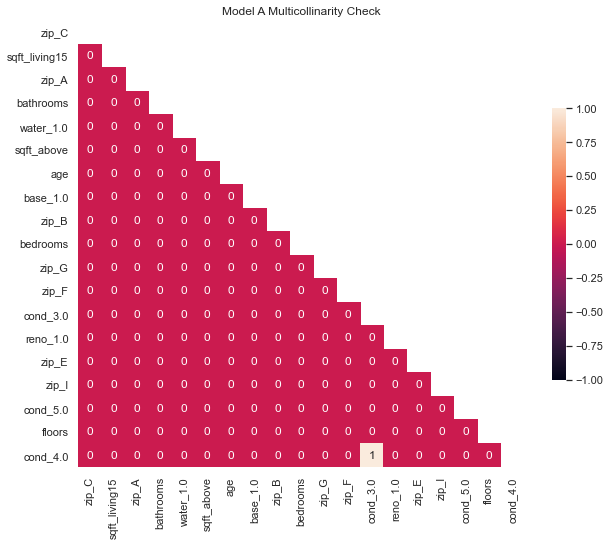

In [1052]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_A].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_A].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model A Multicollinarity Check')
plt.savefig('./Data & Figures/model_A_multicollinarity_check')

In [1053]:
#drop 'cond_4.0' to avoid multicollinearity
preprocessed_A.drop('cond_4.0', axis = 1, inplace = True)

In [1054]:
#redefine X, y training set
X = preprocessed_A.drop(['price'], axis = 1)
y = preprocessed_A['price']

In [1055]:
#redo stepwise selection
result_A = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_A)

Add  zip_C                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  age                            with p-value 4.45035e-290
Add  base_1.0                       with p-value 8.75145e-194
Add  zip_B                          with p-value 6.9763e-191
Add  bedrooms                       with p-value 6.00824e-95
Add  zip_G                          with p-value 9.03639e-88
Add  zip_F                          with p-value 4.2296e-16
Add  cond_3.0                       with p-value 7.71182e-17
Add  reno_1.0                       with p-value 5.11113e-13
Add  zip_E                          with p-value 5.54062e-09
Add  zip_I                          with p-value 6.78986e-10
Add  cond_5.0                       with p-value 1.06607e-07
Add  floor

In [1056]:
#rebuild Model A
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_A]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_A = sm.OLS(y, X_intercept).fit() 

#get summary
model_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2268.
Date:                Sun, 31 Jan 2021   Prob (F-statistic):               0.00
Time:                        03:19:29   Log-Likelihood:                -18578.
No. Observations:               21420   AIC:                         3.720e+04
Df Residuals:                   21400   BIC:                         3.736e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5501      0.028    -19.884      0.000      -0.604      -0.496
zip_C             0.7859      0.016     49.600      0.000       0.755       0.817
sqft_living15     0.1772      0.006     27.739      0.000       0.165       0.190
zip_A             0.7337      0.014     52.164      0.000       0.706       0.761
bathrooms         0.2142      0.009     23.157      0.000       0.196       0.232
water_1.0         2.3150      0.049     47.575      0.000       2.220       2.410
sqft_above        0.5373      0.008     66.073      0.000       0.521       0.553
age               0.1431      0.006     23.120      0.000       0.131       0.155
base_1.0          0.3292      0.011     31.052      0.000       0.308       0.350
zip_B             0.4748      0.015     31.407      0.000       0.445       0.504
bedrooms         -0.1107      0.006    -19.977      0.000      -0.122      -0.100
zip_G             0.3447      0.017     19.784      0.000       0.311       0.379
zip_F            -0.0821      0.018     -4.685      0.000      -0.116      -0.048
cond_3.0         -0.0780      0.010     -7.753      0.000      -0.098      -0.058
reno_1.0          0.1798      0.023      7.865      0.000       0.135       0.225
zip_E             0.1390      0.019      7.259      0.000       0.101       0.176
zip_I             0.1622      0.026      6.268      0.000       0.111       0.213
cond_5.0          0.0838      0.016      5.160      0.000       0.052       0.116
floors           -0.0569      0.011     -5.387      0.000      -0.078      -0.036
cond_2.0         -0.1352      0.046     -2.937      0.003      -0.225      -0.045
==============================================================================
Omnibus:                    17964.927   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1607735.037
Skew:                           3.527   Prob(JB):                         0.00
Kurtosis:                      44.853   Cond. No.                         56.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1057]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_A], y)

#predict yhat using our model
yhat = linreg.predict(X[result_A])
yhat

array([-1.04396899, -0.79988517, -0.33824057, ..., -0.71789283,
       -0.34289998, -0.52898149])

In [1058]:
#get intercept
linreg.intercept_

-0.5501355394147078

In [1059]:
#get coefficients and sort them
coefficients = dict(zip(X[result_A], list(linreg.coef_)))
dict(sorted(coefficients.items(), key = lambda item: item[1]))

{'cond_2.0': -0.13523211025571064,
 'bedrooms': -0.11066913362648308,
 'zip_F': -0.08210151123051121,
 'cond_3.0': -0.07800378763802449,
 'floors': -0.0568537978085886,
 'cond_5.0': 0.08376544156920017,
 'zip_E': 0.13896434716421413,
 'age': 0.14314370392407427,
 'zip_I': 0.16220670743991458,
 'sqft_living15': 0.17720665726244839,
 'reno_1.0': 0.17982888317665463,
 'bathrooms': 0.21423240143100816,
 'base_1.0': 0.32924827330845563,
 'zip_G': 0.3446530600607661,
 'zip_B': 0.47483510890551517,
 'sqft_above': 0.5372882770934392,
 'zip_A': 0.7337234937057023,
 'zip_C': 0.7858900555592189,
 'water_1.0': 2.31497702677724}

**Features that decreases value of the home:**

* 'cond_2.0': -0.13523211025571083,
* 'bedrooms': -0.110669133626482,
* 'zip_F': -0.08210151123051071,
* 'cond_3.0': -0.0780037876380249,
* 'floors': -0.05685379780858867,

**Features that increases value of the home:**
* 'cond_5.0': 0.08376544156919936,
* 'zip_E': 0.1389643471642145,
* 'age': 0.1431437039240746,
* 'zip_I': 0.16220670743991517,
* 'sqft_living15': 0.17720665726244836,
* 'reno_1.0': 0.1798288831766561,
* 'bathrooms': 0.21423240143100827,
* 'base_1.0': 0.32924827330845347,
* 'zip_G': 0.3446530600607671,
* 'zip_B': 0.47483510890551495,
* 'sqft_above': 0.5372882770934376,
* 'zip_A': 0.7337234937057004,
* 'zip_C': 0.7858900555592188,
* 'water_1.0': 2.3149770267772363

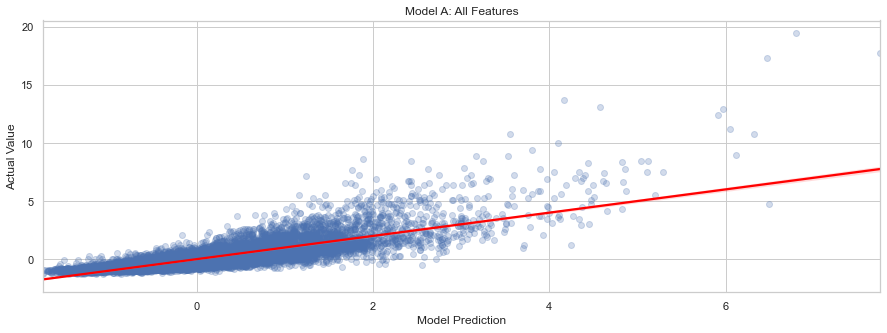

In [1060]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25},color='r')
plt.title('Model A: All Features')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_A_regplot')

## Test Model A

**Recheck for multicollinearity**

The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables (features X) within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.

VIF quantifies how much the variance is inflated.

In [1061]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_A].values, i) for i in range(X[result_A].shape[1])] 
list(zip(result_A, vif))

[('zip_C', 1.8249194859859676),
 ('sqft_living15', 2.6318276577199327),
 ('zip_A', 4.290652617544419),
 ('bathrooms', 24.5808924376999),
 ('water_1.0', 1.0400373391710502),
 ('sqft_above', 3.148057722816477),
 ('age', 2.242364820725818),
 ('base_1.0', 2.7822492090783775),
 ('zip_B', 1.8220859772868632),
 ('bedrooms', 17.341313318594572),
 ('zip_G', 1.5956441254772722),
 ('zip_F', 1.459053857213612),
 ('cond_3.0', 4.023563239782993),
 ('reno_1.0', 1.1559974679711245),
 ('zip_E', 1.4476228181714277),
 ('zip_I', 1.179919990138253),
 ('cond_5.0', 1.335026794416748),
 ('floors', 14.997470031513634),
 ('cond_2.0', 1.0299440989722572)]

While the p-values indicate that all of the current features are impactful, the variance inflation factor indicates that there is moderate multicollinearity between our variables.  A rule of thumb commonly used in practice is if a VIF is > 10, we have high multicollinearity, and the parameter estimates will have large standard errors because of this. We see here those 'problematic' features are:

* 'cond_3.0', 23.10854748754023
* 'floors', 17.115709258109163

Let's recheck for multicollinearity.

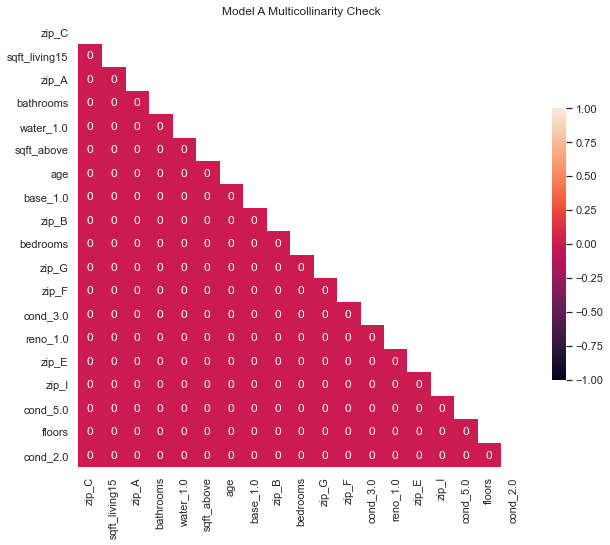

In [1062]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_A].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_A].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model A Multicollinarity Check')
plt.savefig('./Data & Figures/model_A_multicollinarity_check')

**Recheck for normality**

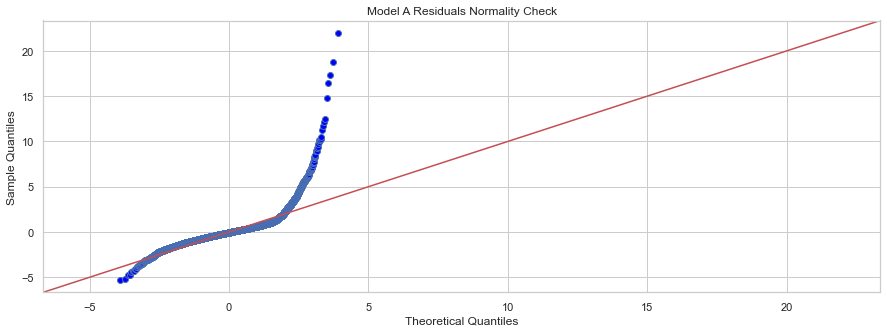

<Figure size 432x288 with 0 Axes>

In [1063]:
#recheck for normality
fig = sm.graphics.qqplot(model_A.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model A Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_A_residuals_qqplot')

**Recheck for homoscedasticity**

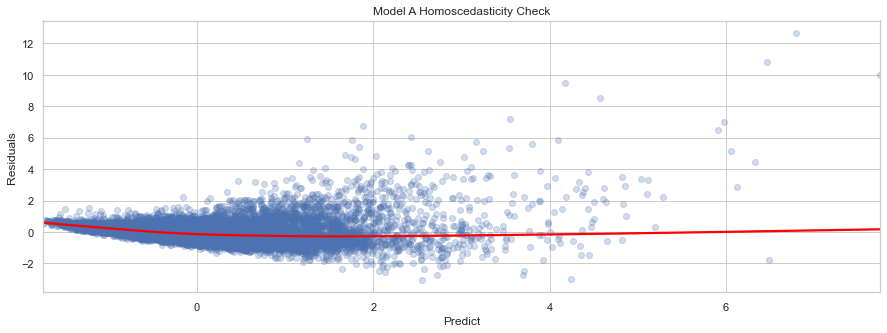

<Figure size 432x288 with 0 Axes>

In [1064]:
#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_A.predict(), 
            y = model_A.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25})
plt.title('Model A Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_A_homoscedasticity_regplot')

In [1065]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_A.resid, model_A.model.exog)
list(zip(name, test))

[('F statistic', 1.0157928175913467), ('p-value', 0.20896254809615292)]

**Recheck for overfitting: K-Fold Cross Validation**

In [1066]:
#cross-validation to check for overfitting
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

linreg = LinearRegression()

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X, y, cv = 10, scoring = 'neg_mean_squared_error')
cv_result

array([-0.44710665, -0.2198019 , -0.29026356, -0.41013214, -0.31306042,
       -0.32327282, -0.30570116, -0.34842427, -0.39989588, -0.31003089])

In [1067]:
#the accuracy of the model is the average of the accuracy of each fold
cv_result.mean()

-0.33676896902113007

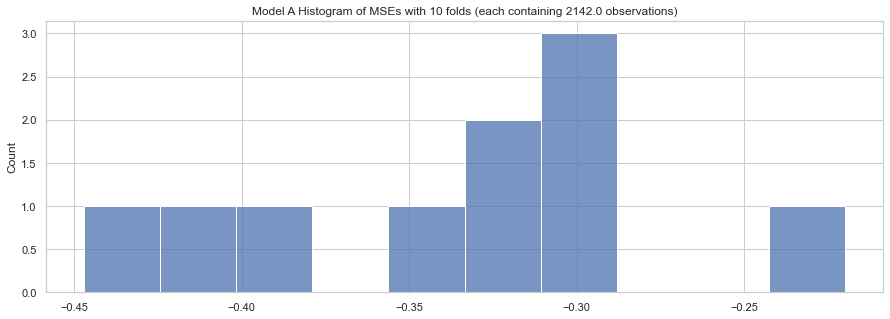

In [1068]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model A Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_A) / folds, 0)));
plt.savefig('./Data & Figures/model_A_cv_result_histplot')

Our regression visualization suggests that there are some splits for which our fitted model performs significantly less well.

## Validate Model A

In order to get a good sense of how well our model will be doing on new instances, we'll have to perform a so-called "train-test-split". What we'll be doing here, is take a sample of the data that serves as input to "train" our model - fit a linear regression and compute the parameter estimates for our variables, and calculate how well our predictive performance is doing comparing the actual targets y and the fitted yhat obtained by our model.

* Underfitting happens when a model cannot learn the training data, nor can it generalize to new data.
* Overfitting happens when a model learns the training data too well. In fact, so well that it is not generalizeable to new data

In [1069]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[result_A], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

17136 17136 4284 4284


In [1070]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [1071]:
#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [1072]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

0.5625265909631906
0.6286713292932756


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

In [1073]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
'Accuracy: {}%'.format(int(round(accuracy * 100)))

'Accuracy: 66%'

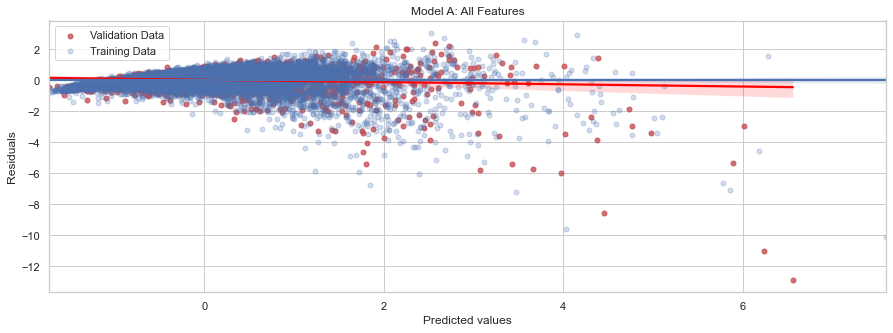

<Figure size 432x288 with 0 Axes>

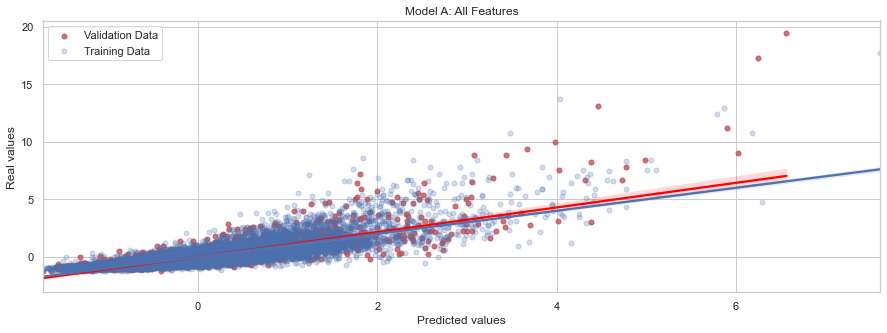

<Figure size 432x288 with 0 Axes>

In [1074]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model A: All Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_B_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model A: All Features')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_B_predictions_regplot')

**Bias-Variance Tradeoff**

* Bias arises when wrong assumptions are made when training a model. For example, an interaction effect is missed, or we didn't catch a certain polynomial relationship. Because of this, our algorithm misses the relevant relations between predictors and the target variable. Note how this is similar to underfitting!

* Variance arises when a model is too sensitive to small fluctuations in the training set. When variance is high, random noise in the training data is modeled, rather than the intended outputs. This is overfitting!

The balance between bias and variance is a trade-off. We can reduce the variance but then there is a risk of running a bigger bias, and vice versa. Bias is usually associated with low model complexity, variance with high model complexity. There is generally a "sweet spot" in-between, compromising between bias and variance.

In [1075]:
#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

In [1076]:
#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [1077]:
#function bias() to calculate the bias of a model's predictions given the actual data
def bias(y, y_hat):
    return np.mean(y_hat - y)

#function variance() to calculate the variance of a model's predictions
def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

In [1078]:
#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

Train bias: 0.1866438695124231 
Train variance: 0.2106811199621985


In [1079]:
#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Test bias: 0.17987848096082257 
Test variance: 0.20526058148544082


In [1080]:
import pickle

#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_A.pkl','wb'))

In [1081]:
#summary table
summary_table_1 = pd.DataFrame({'Model': [], 'Description':[], ' Num Features' : [], 
                                'r2': [], 'Accuracy':[], 
                                'RMSE Train': [], 'RMSE Test': [],
                                'Bias Train': [], 'Bias Test': [], 'Variance Train': [], 'Variance Test': [],
                                'Cross Validation': [],
                                'Multicollinearity': [], 'Normality': [], 'Homoscedasticity': []})
summary_table_1.loc[0] = ['Model A', 'All features', len(result_A), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'F', 'F']
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,RMSE Train,RMSE Test,Bias Train,Bias Test,Variance Train,Variance Test,Cross Validation,Multicollinearity,Normality,Homoscedasticity
0,Model A,All features,19.0,0.668177,66.236718,0.562527,0.628671,0.186644,0.179878,0.210681,0.205261,-0.336769,P,F,F


# MODEL B 
## REMOVE OUTLIERS THAT ARE 3 STD AWAY FROM THE MEAN

In [1082]:
#review
preprocessed_A.columns

Index(['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'age',
       'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0', 'reno_1.0',
       'cond_2.0', 'cond_3.0', 'cond_5.0', 'zip_A', 'zip_B', 'zip_C', 'zip_D',
       'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I'],
      dtype='object')

In [1083]:
#removie outliers in 'bedrooms'
count = 0
bedrooms_outliers = []
mean = np.mean(preprocessed_A['bedrooms'])
std = np.std(preprocessed_A['bedrooms'])
cut_off = np.std(preprocessed_A['bedrooms']) * 3 

for idx, row in preprocessed_A['bedrooms'].T.iteritems():
    if abs(row - mean) >= cut_off:
        count += 1
        preprocessed_A.drop(idx, inplace = True)
count

61

In [1084]:
#removie outliers in 'bathrooms'
count = 0
bathrooms_outliers = []
mean = np.mean(preprocessed_A['bathrooms'])
std = np.std(preprocessed_A['bathrooms'])
cut_off = np.std(preprocessed_A['bathrooms']) * 3 

for idx, row in preprocessed_A['bathrooms'].T.iteritems():
    if abs(row - mean) >= cut_off:
        count += 1
        preprocessed_A.drop(idx, inplace = True)
count

171

In [1085]:
#create new dataframe excluding outliers
preprocessed_B = preprocessed_A[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 
                                 'age', 'bedrooms', 'bathrooms', 'floors', 
                                 'water_1.0', 'base_1.0', 'reno_1.0',
                                 'cond_2.0', 'cond_3.0', 'cond_5.0', 
                                 'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

In [1086]:
X = preprocessed_B.drop(['price'], axis = 1)
y = preprocessed_B['price']

## RECURSIVE FEATURE RANKING

Stepwise Selection selects features based on p-value. RFE ranks the variable on the basis on linear regression fit.
By combining them, we select for the 10 most important features.

RFE is effective at selecting those features in a training dataset that are more or most relevant in predicting the target variable.

RFE assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [1087]:
#feature ranking with recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X, y.values.ravel()) 
selector.support_

array([ True, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False,  True,  True,
        True,  True, False,  True,  True])

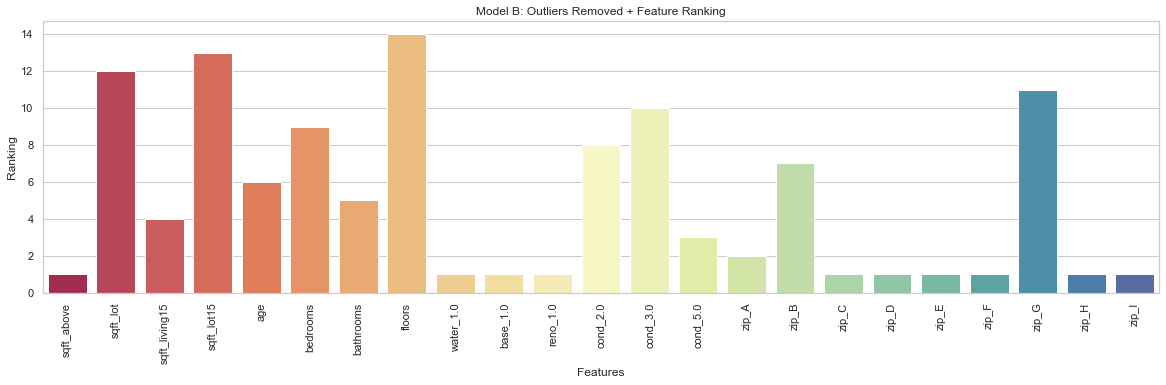

<Figure size 432x288 with 0 Axes>

In [1088]:
#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X.columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model B: Outliers Removed + Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/recursive_features_elimination')

We can see here that the best predictors/ features are 

* 'sqft_above'
* 'water_1.0'
* 'base_1.0'
* 'reno_1.0'
* 'zip_C'
* 'zip_D'
* 'zip_E'
* 'zip_F'
* 'zip_H'
* 'zip_I'

In [1089]:
#fit the linear regression model again using the selected columns
selected_features = X.columns[selector.support_ ]

linreg.fit(X[selected_features], y)

LinearRegression()

In [1090]:
#get intercept
linreg.intercept_

-0.052336240386231275

In [1091]:
#get coefficients and sort them
coefficients = dict(zip(X[selected_features], list(linreg.coef_)))
dict(sorted(coefficients.items(), key = lambda item: item[1]))

{'zip_F': -0.746885291014628,
 'zip_H': -0.6612045301289374,
 'zip_D': -0.6471945082488622,
 'zip_E': -0.5247772178946191,
 'zip_I': -0.44281983494903393,
 'zip_C': 0.22657023991059272,
 'reno_1.0': 0.34266863296564737,
 'base_1.0': 0.47371203003217127,
 'sqft_above': 0.5706740713374334,
 'water_1.0': 2.2149759839449796}

**Features that decrease value of a home:**
* 'zip_F': -0.746885291014628
* 'zip_H': -0.6612045301289374
* 'zip_D': -0.6471945082488622
* 'zip_E': -0.5247772178946191
* 'zip_I': -0.44281983494903393
 
**Features that increase value of a home:**
* 'zip_C': 0.22657023991059272
* 'reno_1.0': 0.34266863296564737
* 'base_1.0': 0.47371203003217127
* 'sqft_above': 0.5706740713374334
* 'water_1.0': 2.2149759839449796

## Build Model B

In [1092]:
#build model B 
#interecept is not included by default and should be added manually
X_in = X[selected_features]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_B = sm.OLS(y, X_intercept).fit() 

#get summary
model_B.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     3278.
Date:                Sun, 31 Jan 2021   Prob (F-statistic):               0.00
Time:                        03:19:50   Log-Likelihood:                -17840.
No. Observations:               21188   AIC:                         3.570e+04
Df Residuals:                   21177   BIC:                         3.579e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0523      0.006     -8.237      0.000      -0.065      -0.040
sqft_above     0.5707      0.004    133.367      0.000       0.562       0.579
water_1.0      2.2150      0.050     44.696      0.000       2.118       2.312
base_1.0       0.4737      0.008     57.088      0.000       0.457       0.490
reno_1.0       0.3427      0.021     16.006      0.000       0.301       0.385
zip_C          0.2266      0.012     18.164      0.000       0.202       0.251
zip_D         -0.6472      0.015    -43.270      0.000      -0.677      -0.618
zip_E         -0.5248      0.016    -32.447      0.000      -0.556      -0.493
zip_F         -0.7469      0.015    -50.629      0.000      -0.776      -0.718
zip_H         -0.6612      0.016    -41.927      0.000      -0.692      -0.630
zip_I         -0.4428      0.024    -18.571      0.000      -0.490      -0.396
==============================================================================
Omnibus:                    13254.628   Durbin-Watson:                   1.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           299158.300
Skew:                           2.623   Prob(JB):                         0.00
Kurtosis:                      20.645   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

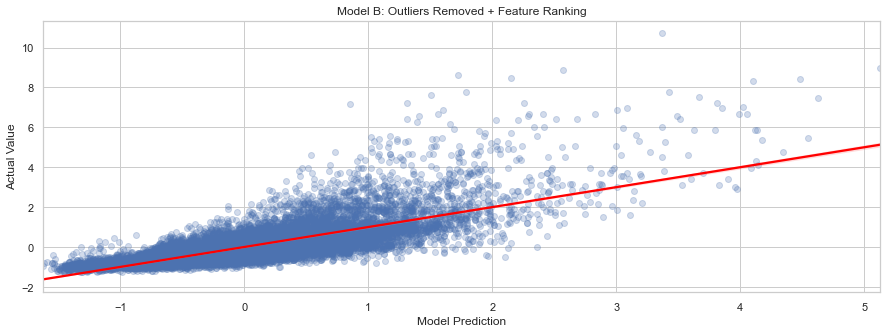

In [1093]:
#predict yhat using our model
yhat = linreg.predict(X[selected_features])
yhat

#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25},color='r')
plt.title('Model B: Outliers Removed + Feature Ranking')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_B_regplot')

## Test Model B

In [1094]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[selected_features].values, i) for i in range(X[selected_features].shape[1])] 
list(zip(selected_features, vif))

[('sqft_above', 1.1119759321952951),
 ('water_1.0', 1.0272357322090344),
 ('base_1.0', 1.218706679384804),
 ('reno_1.0', 1.0332863962690795),
 ('zip_C', 1.097444005578701),
 ('zip_D', 1.0257503220474957),
 ('zip_E', 1.0451414734301279),
 ('zip_F', 1.019147829462644),
 ('zip_H', 1.0092773860731128),
 ('zip_I', 1.0130612795352332)]

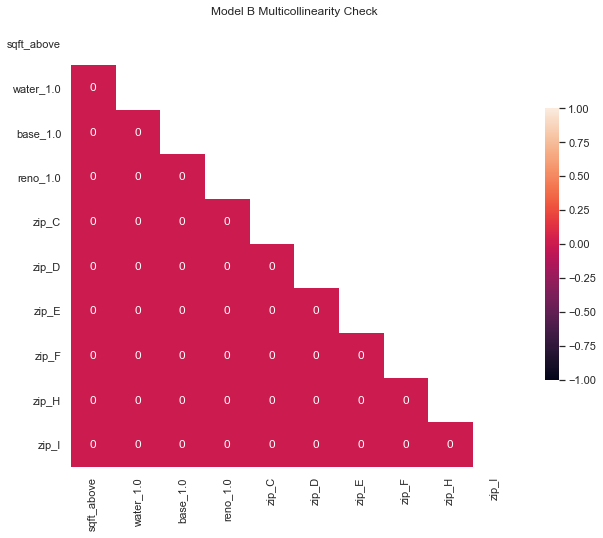

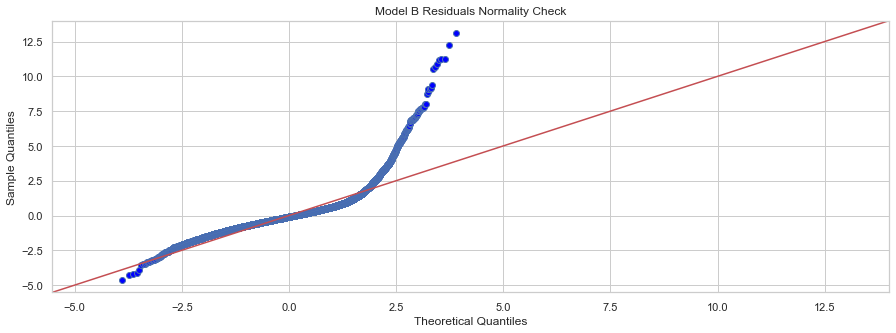

<Figure size 432x288 with 0 Axes>

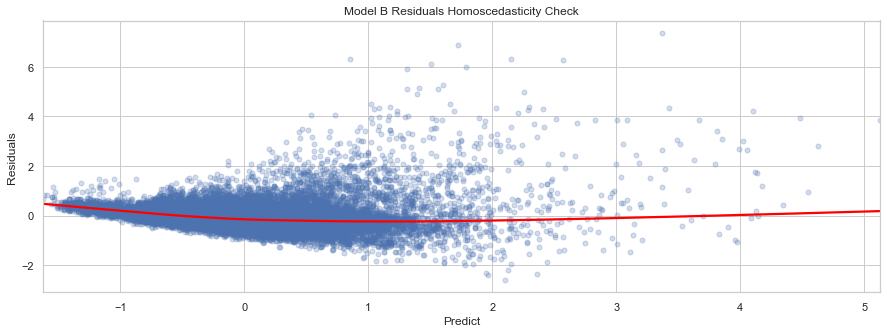

<Figure size 432x288 with 0 Axes>

In [1095]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[selected_features].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[selected_features].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model B Multicollinearity Check')
plt.savefig('./Data & Figures/model_B_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_B.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model B Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_B_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_B.predict(), 
            y = model_B.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25,'alpha': 0.25})
plt.title('Model B Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_B_homoscedasticity_regplot')

In [1096]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_B.resid, model_B.model.exog)
list(zip(name, test))

[('F statistic', 1.1303410844387611), ('p-value', 1.4892247197856945e-10)]

In [1097]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[selected_features], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

-0.3180497252139539


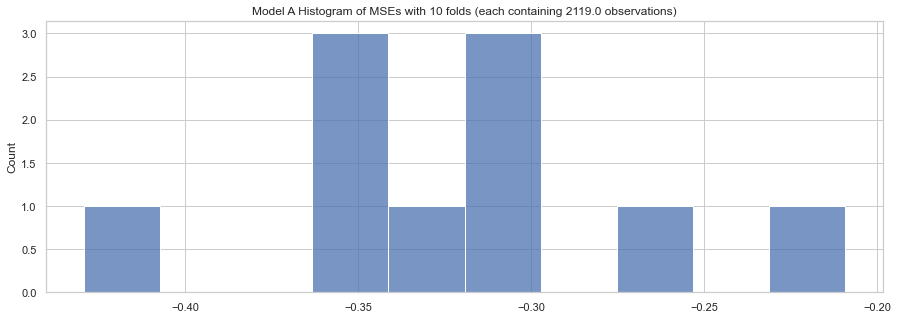

In [1098]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model A Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_A) / folds, 0)));
plt.savefig('./Data & Figures/model_B_cv_result_histplot')

Without log-transformation of data, we keep failing the normality and homoscedasticity assumptions. 

## Validate Model B

In [1099]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

#calculate training and test RMSE
train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

16950 16950 4238 4238
0.5624862178378017
0.5583188110166062


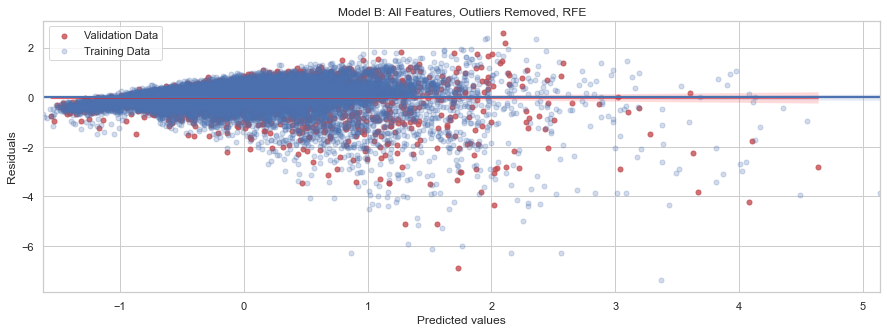

<Figure size 432x288 with 0 Axes>

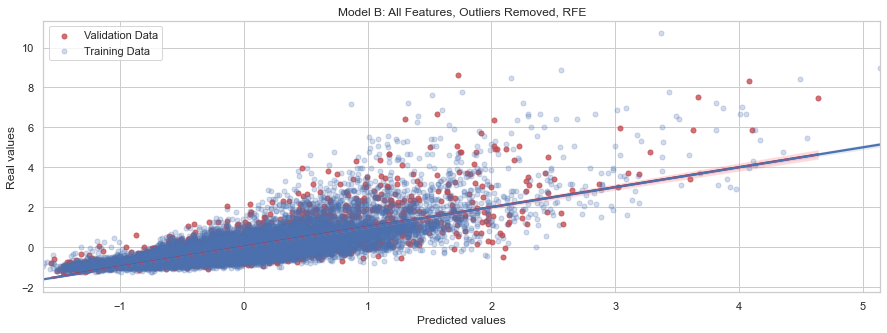

<Figure size 432x288 with 0 Axes>

In [1100]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model B: All Features, Outliers Removed, RFE')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_B_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model B: All Features, Outliers Removed, RFE')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_B_predictions_regplot')

In [1101]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
'Accuracy: {}%'.format(int(round(accuracy * 100)))

'Accuracy: 61%'

In [1102]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: 0.12839396166672937 
Train variance: 0.22190382567195135
Test bias: 0.12270141633234283 
Test variance: 0.22544062252045535


In [1103]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_B.pkl','wb'))

In [1104]:
summary_table_1.loc[1] = ['Model B', 'All features, outliers removed, RFE', len(selected_features), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'F', 'F']
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,RMSE Train,RMSE Test,Bias Train,Bias Test,Variance Train,Variance Test,Cross Validation,Multicollinearity,Normality,Homoscedasticity
0,Model A,All features,19.0,0.668177,66.236718,0.562527,0.628671,0.186644,0.179878,0.210681,0.205261,-0.336769,P,F,F
1,Model B,"All features, outliers removed, RFE",10.0,0.607514,60.932733,0.562486,0.558319,0.128394,0.122701,0.221904,0.225441,-0.318050,P,F,F


# MODEL C
## POLYNOMIAL REGRESSION

Without log-transformation of data, we keep failing the normality and homoscedasticity assumptions. The troublesome features are 'price', 'sqft_above', 'sqft_lot', 'sqft_living15', and 'sqft_lot15'.

Model C will be a refinement of Model A, since Model B (with outliers removed) did not improve and we don't want to remove outliers without a convincing reason.

In [1105]:
#create new dataframe
preprocessed_C = clean[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15',
                      'age', 'bedrooms', 'bathrooms', 'floors', 
                      'water_1.0', 'base_1.0', 'reno_1.0',
                      'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0',
                      'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

preprocessed_C.head(2)

,price,sqft_above,sqft_lot,sqft_living15,sqft_lot15,age,bedrooms,bathrooms,floors,water_1.0,...,cond_5.0,zip_A,zip_B,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I
15937,-0.740571,-1.099527,-0.169225,-1.441766,-0.170986,0.955962,3,1.00,1.0,0,...,0,0,0,0,0,1,0,0,0,0
20963,-0.384457,-1.075393,-0.340062,-0.799934,-0.423750,-1.357975,2,1.75,1.5,0,...,0,0,0,0,0,0,0,1,0,0


In [1106]:
#transform non-normal features
preprocessed_C['sqft_above_poly'] = preprocessed_C['sqft_above']**2
preprocessed_C['sqft_lot_poly'] = preprocessed_C['sqft_lot']**2
preprocessed_C['sqft_living15_poly'] = preprocessed_C['sqft_living15']**2
preprocessed_C['sqft_lot15_poly'] = preprocessed_C['sqft_lot15']**2

In [1107]:
#drop old values
preprocessed_C.drop(['sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15'], axis = 1, inplace = True)

In [1108]:
#review dataframe
preprocessed_C.head(2)

,price,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,reno_1.0,cond_2.0,cond_3.0,...,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I,sqft_above_poly,sqft_lot_poly,sqft_living15_poly,sqft_lot15_poly
15937,-0.740571,0.955962,3,1.00,1.0,0,1,0,0,1,...,0,1,0,0,0,0,1.208959,0.028637,2.078689,0.029236
20963,-0.384457,-1.357975,2,1.75,1.5,0,1,0,0,1,...,0,0,0,1,0,0,1.156469,0.115642,0.639894,0.179564


In [1109]:
#redefine X_train and y_train
X = preprocessed_C.drop(['price'], axis = 1)
y = preprocessed_C['price']

In [1110]:
#apply stepwise function to make sure we only select impactful features
result_C = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_C)

Add  sqft_living15_poly             with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  age                            with p-value 0.0
Add  sqft_above_poly                with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  zip_C                          with p-value 1.33809e-274
Add  zip_A                          with p-value 5.42116e-283
Add  zip_B                          with p-value 1.82843e-241
Add  zip_G                          with p-value 4.07446e-163
Add  base_1.0                       with p-value 1.61889e-25
Add  floors                         with p-value 7.43605e-50
Add  zip_I                          with p-value 4.1511e-21
Add  reno_1.0                       with p-value 6.58981e-12
Add  cond_3.0                       with p-value 6.99716e-15
Add  bedrooms                       with p-value 1.27428e-10
Add  zip_F                          with p-value 1.07215e-07
Add  cond_2.0                       with p-value 1.48159e-06


## Build Model C

In [1111]:
#interecept is not included by default and should be added manually
X_in = X[result_C]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_C = sm.OLS(y, X_intercept).fit() 

#get summary
model_C.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     1837.
Date:                Sun, 31 Jan 2021   Prob (F-statistic):               0.00
Time:                        03:20:01   Log-Likelihood:                -20034.
No. Observations:               21420   AIC:                         4.011e+04
Df Residuals:                   21400   BIC:                         4.027e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.9499      0.023    -83.363      0.000      -1.996      -1.904
sqft_living15_poly     0.0803      0.003     29.699      0.000       0.075       0.086
bathrooms              0.4568      0.009     50.726      0.000       0.439       0.474
age                    0.1643      0.007     25.189      0.000       0.152       0.177
sqft_above_poly        0.1187      0.002     52.351      0.000       0.114       0.123
water_1.0              2.4589      0.052     47.400      0.000       2.357       2.561
zip_C                  0.8438      0.017     48.994      0.000       0.810       0.878
zip_A                  0.5149      0.015     34.432      0.000       0.486       0.544
zip_B                  0.5483      0.016     33.275      0.000       0.516       0.581
zip_G                  0.4381      0.019     23.213      0.000       0.401       0.475
base_1.0               0.1590      0.010     15.343      0.000       0.139       0.179
floors                 0.1613      0.011     14.671      0.000       0.140       0.183
zip_I                  0.2150      0.028      7.701      0.000       0.160       0.270
reno_1.0               0.2037      0.024      8.327      0.000       0.156       0.252
cond_3.0              -0.0839      0.010     -8.266      0.000      -0.104      -0.064
bedrooms               0.0375      0.006      6.586      0.000       0.026       0.049
zip_F                 -0.1125      0.019     -5.897      0.000      -0.150      -0.075
cond_2.0              -0.2433      0.049     -4.951      0.000      -0.340      -0.147
sqft_lot_poly          0.0011      0.000      4.204      0.000       0.001       0.002
zip_D                 -0.0532      0.019     -2.758      0.006      -0.091      -0.015
==============================================================================
Omnibus:                    11024.395   Durbin-Watson:                   1.213
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           307520.757
Skew:                           1.917   Prob(JB):                         0.00
Kurtosis:                      21.162   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1112]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_C], y)

#predict yhat using our model
yhat = linreg.predict(X[result_C])
yhat

array([-0.67647425, -0.35447544, -0.14501706, ..., -1.16506648,
       -0.41445538, -0.27414211])

In [1113]:
#get intercept
linreg.intercept_

-1.9498919341453482

In [1114]:
#get coefficients and sort them
coefficients = dict(zip(X[result_C], list(linreg.coef_)))
dict(sorted(coefficients.items(), key = lambda item: item[1]))

{'cond_2.0': -0.2433027790795079,
 'zip_F': -0.11252118495890923,
 'cond_3.0': -0.08387322041156688,
 'zip_D': -0.0531555320448824,
 'sqft_lot_poly': 0.0010537361785556562,
 'bedrooms': 0.037548305422543005,
 'sqft_living15_poly': 0.08027434416920898,
 'sqft_above_poly': 0.11872219087512066,
 'base_1.0': 0.15897162371141146,
 'floors': 0.16134860006152127,
 'age': 0.16430823902341707,
 'reno_1.0': 0.20370398834588144,
 'zip_I': 0.2149882161375932,
 'zip_G': 0.43808971399413604,
 'bathrooms': 0.4568273734050319,
 'zip_A': 0.5148911510087841,
 'zip_B': 0.5483301343353947,
 'zip_C': 0.8438471312785515,
 'water_1.0': 2.4589278060947253}

**Features that decreases value of the home:**

* 'cond_2.0': -0.2433027790795079
* 'zip_F': -0.11252118495890923
* 'cond_3.0': -0.08387322041156688
* 'zip_D': -0.0531555320448824

**Features that increases value of the home:**
* 'sqft_lot_poly': 0.0010537361785556562
* 'bedrooms': 0.037548305422543005
* 'sqft_living15_poly': 0.08027434416920898
* 'sqft_above_poly': 0.11872219087512066
* 'base_1.0': 0.15897162371141146
* 'floors': 0.16134860006152127
* 'age': 0.16430823902341707
* 'reno_1.0': 0.20370398834588144
* 'zip_I': 0.2149882161375932
* 'zip_G': 0.43808971399413604
* 'bathrooms': 0.4568273734050319
* 'zip_A': 0.5148911510087841
* 'zip_B': 0.5483301343353947
* 'zip_C': 0.8438471312785515
* 'water_1.0': 2.4589278060947253

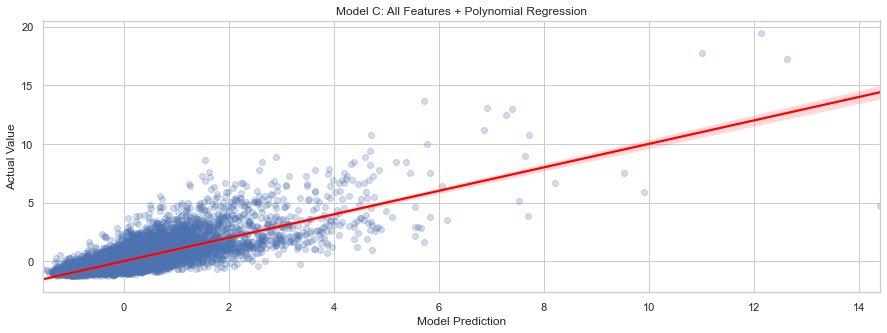

In [1115]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25},color='r')
plt.title('Model C: All Features + Polynomial Regression')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_C_regplot')

## Test Model C

In [1116]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_C].values, i) for i in range(X[result_C].shape[1])] 
list(zip(result_C, vif))

[('sqft_living15_poly', 1.8864195818784228),
 ('bathrooms', 22.928114466161347),
 ('age', 2.0781327505304863),
 ('sqft_above_poly', 1.8267239688609864),
 ('water_1.0', 1.032228272393464),
 ('zip_C', 1.877564122678017),
 ('zip_A', 4.039269968839059),
 ('zip_B', 1.8689912232367676),
 ('zip_G', 1.6363040741077899),
 ('base_1.0', 2.363997403986547),
 ('floors', 14.774804385517237),
 ('zip_I', 1.1975449136532992),
 ('reno_1.0', 1.1511365679235355),
 ('cond_3.0', 3.505262016907805),
 ('bedrooms', 17.621751934162507),
 ('zip_F', 1.4579586942617566),
 ('cond_2.0', 1.019910364530641),
 ('sqft_lot_poly', 1.0156038710061985),
 ('zip_D', 1.456631928005862)]

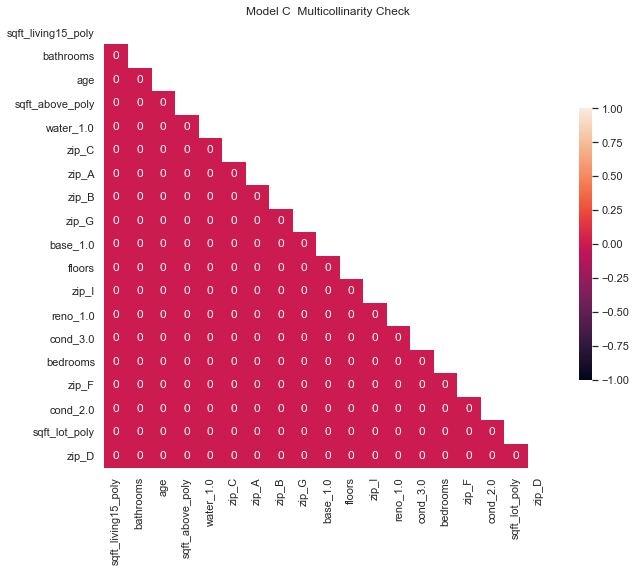

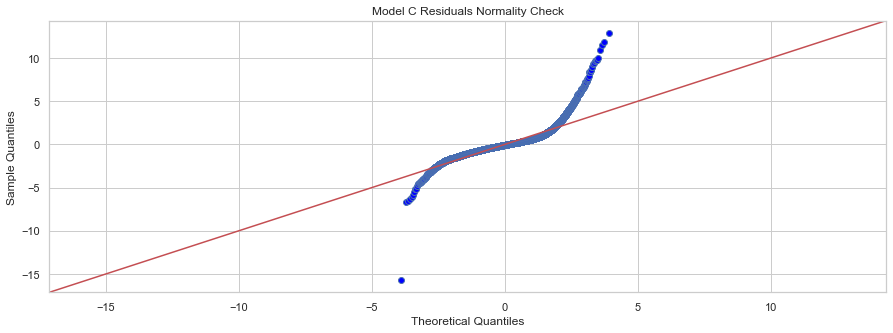

<Figure size 432x288 with 0 Axes>

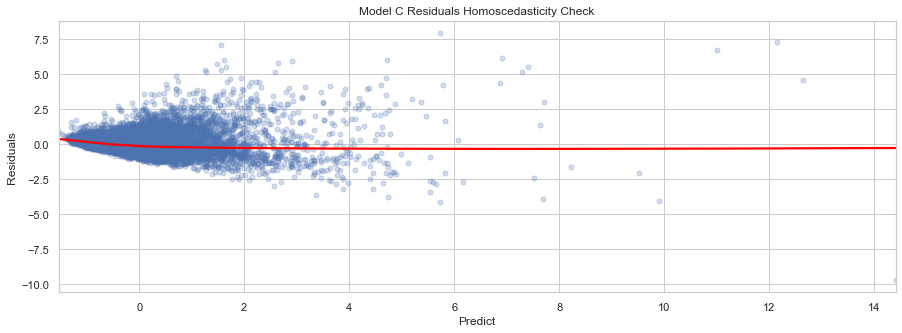

<Figure size 432x288 with 0 Axes>

In [1117]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_C].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_C].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model C  Multicollinarity Check')
plt.savefig('./Data & Figures/model_C_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_C.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model C Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_C_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_C.predict(), 
            y = model_C.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25,'alpha':0.25})
plt.title('Model C Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_C_homoscedasticity_regplot')

In [1118]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_C.resid, model_C.model.exog)
list(zip(name, test))

[('F statistic', 1.1492531751257562), ('p-value', 3.2749221992642826e-13)]

In [1119]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[result_C], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

-0.3864108608759035


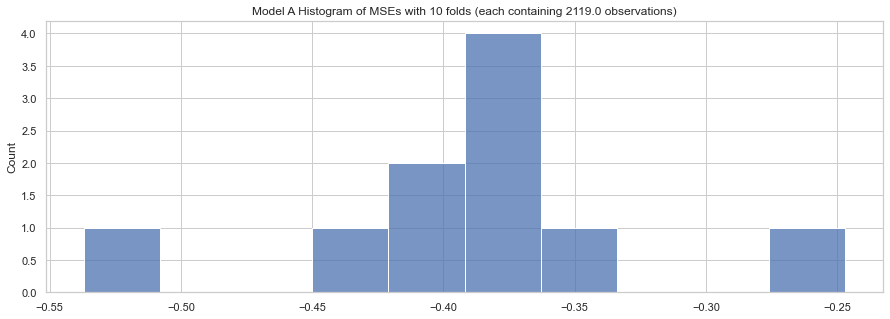

In [1120]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model A Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_A) / folds, 0)));
plt.savefig('./Data & Figures/model_C_cv_result_histplot')

## Validate Model C

In [1121]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[result_C], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.6152325525353235
0.6248189420378881


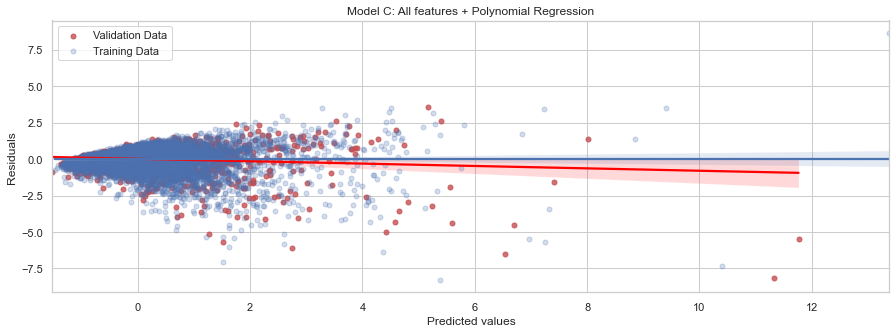

<Figure size 432x288 with 0 Axes>

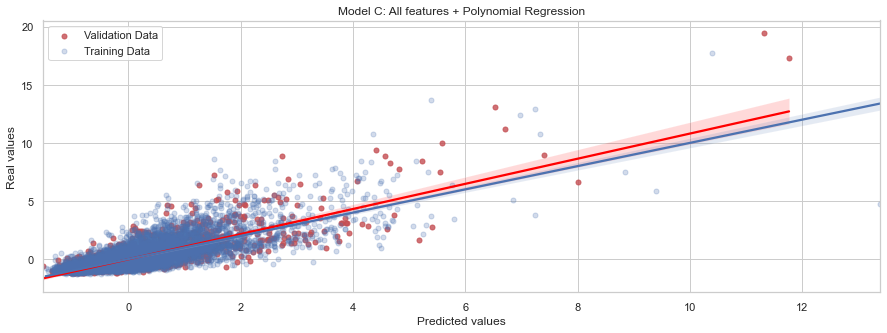

<Figure size 432x288 with 0 Axes>

In [1122]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model C: All features + Polynomial Regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_C_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model C: All features + Polynomial Regression')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_C_predictions_regplot')

In [1123]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 67%'

In [1124]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: -1.3257345975031278 
Train variance: 0.1657514363998529
Test bias: -1.3313392696514037 
Test variance: 0.16310249878770366


In [1125]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_C.pkl','wb'))

In [1126]:
summary_table_1.loc[2] = ['Model C', 'All features + Polynomial Regression', len(result_C), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'F', 'F']
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,RMSE Train,RMSE Test,Bias Train,Bias Test,Variance Train,Variance Test,Cross Validation,Multicollinearity,Normality,Homoscedasticity
0,Model A,All features,19.0,0.668177,66.236718,0.562527,0.628671,0.186644,0.179878,0.210681,0.205261,-0.336769,P,F,F
1,Model B,"All features, outliers removed, RFE",10.0,0.607514,60.932733,0.562486,0.558319,0.128394,0.122701,0.221904,0.225441,-0.318050,P,F,F
2,Model C,All features + Polynomial Regression,19.0,0.619854,66.649241,0.615233,0.624819,-1.325735,-1.331339,0.165751,0.163102,-0.386411,P,F,F


# MODEL D
## log(X)

In [1127]:
preprocessed_log_D = clean[['price', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]
preprocessed_log_D.head()

,price,sqft_above_log,sqft_lot_log,sqft_living15_log,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,...,cond_5.0,zip_A,zip_B,zip_C,zip_E,zip_D,zip_F,zip_G,zip_H,zip_I
15937,-0.740571,-1.443346,0.011001,-1.932101,0.955962,3,1.00,1.0,0,1,...,0,0,0,0,1,0,0,0,0,0
20963,-0.384457,-1.390746,-2.297864,-0.818484,-1.357975,2,1.75,1.5,0,1,...,0,0,0,0,0,0,0,1,0,0
7614,-0.550073,-1.913036,-0.734773,-0.673521,0.989991,3,1.00,1.0,0,1,...,0,1,0,0,0,0,0,0,0,0
3257,-0.438575,-1.552231,-0.093192,0.075960,1.092076,2,1.00,1.0,0,1,...,1,1,0,0,0,0,0,0,0,0
16723,-0.479367,-0.044048,-0.724104,-1.400849,1.500418,5,2.00,1.5,0,0,...,0,1,0,0,0,0,0,0,0,0


In [1128]:
#drop p-value > 0.05
#preprocessed_log_D.drop('bathrooms', axis = 1)

In [1129]:
#drop p-value > 0.05
#preprocessed_log_D.drop('zip_C', axis = 1)

In [1130]:
X = preprocessed_log_D.drop(['price'], axis=1)
y = preprocessed_log_D['price']

In [1131]:
#apply stepwise function
result_D = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_D)

Add  sqft_above_log                 with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  sqft_living15_log              with p-value 0.0
Add  base_1.0                       with p-value 2.67268e-274
Add  zip_B                          with p-value 3.88126e-162
Add  age                            with p-value 3.64434e-106
Add  bathrooms                      with p-value 2.4632e-184
Add  zip_G                          with p-value 4.03059e-104
Add  bedrooms                       with p-value 1.67036e-81
Add  zip_E                          with p-value 1.74756e-17
Add  zip_I                          with p-value 4.51794e-18
Add  sqft_lot_log                   with p-value 3.50448e-13
Add  cond_5.0                       with p-value 5.36105e-09
Add  reno_1.0                       with p-value 5.54751e-07
Add  cond_3.0                       with p-value 1.33909e-05

## Build Model D

In [1132]:
#build model in statsmodels
#interecept is not included by default and should be added manually
X_in = X[result_D]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_D = sm.OLS(y, X_intercept).fit() 

#get summary
model_D.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1914.
Date:                Sun, 31 Jan 2021   Prob (F-statistic):               0.00
Time:                        03:20:24   Log-Likelihood:                -20119.
No. Observations:               21420   AIC:                         4.028e+04
Df Residuals:                   21401   BIC:                         4.043e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.8575      0.028    -30.720      0.000      -0.912      -0.803
sqft_above_log        0.4154      0.009     46.933      0.000       0.398       0.433
zip_A                 0.7798      0.016     50.207      0.000       0.749       0.810
zip_C                 0.8628      0.017     50.764      0.000       0.829       0.896
water_1.0             2.4149      0.052     46.204      0.000       2.312       2.517
sqft_living15_log     0.1812      0.007     26.756      0.000       0.168       0.194
base_1.0              0.2608      0.011     23.264      0.000       0.239       0.283
zip_B                 0.5115      0.016     31.516      0.000       0.480       0.543
age                   0.1668      0.007     25.592      0.000       0.154       0.180
bathrooms             0.3086      0.010     31.751      0.000       0.290       0.328
zip_G                 0.3944      0.019     21.132      0.000       0.358       0.431
bedrooms             -0.1131      0.006    -18.550      0.000      -0.125      -0.101
zip_E                 0.1717      0.021      8.348      0.000       0.131       0.212
zip_I                 0.2053      0.028      7.376      0.000       0.151       0.260
sqft_lot_log          0.0373      0.005      6.994      0.000       0.027       0.048
cond_5.0              0.0767      0.017      4.410      0.000       0.043       0.111
reno_1.0              0.1359      0.025      5.535      0.000       0.088       0.184
cond_3.0             -0.0476      0.011     -4.441      0.000      -0.069      -0.027
zip_F                -0.0756      0.019     -4.015      0.000      -0.113      -0.039
==============================================================================
Omnibus:                    20709.411   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3010263.665
Skew:                           4.313   Prob(JB):                         0.00
Kurtosis:                      60.432   Cond. No.                         53.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1133]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_D], y)

#predict yhat using our model
yhat = linreg.predict(X[result_D])
yhat

array([-1.29316773, -0.97428318, -0.62661679, ..., -0.59519044,
       -0.30646373, -0.4144427 ])

In [1134]:
#get intercept
linreg.intercept_

-0.8574728935100197

In [1135]:
#get coefficients and sort them
coefficients = dict(zip(X[result_D], list(linreg.coef_)))
dict(sorted(coefficients.items(), key = lambda item: item[1]))

{'bedrooms': -0.11314336324895716,
 'zip_F': -0.0756059500161417,
 'cond_3.0': -0.047646674050632026,
 'sqft_lot_log': 0.037287556196191576,
 'cond_5.0': 0.07674074714114522,
 'reno_1.0': 0.13590699028661635,
 'age': 0.1667938374257938,
 'zip_E': 0.1717221632209878,
 'sqft_living15_log': 0.18121155097583894,
 'zip_I': 0.20527433643556683,
 'base_1.0': 0.26080364480991103,
 'bathrooms': 0.3086494266156202,
 'zip_G': 0.39436948876795436,
 'sqft_above_log': 0.4153772284846073,
 'zip_B': 0.5115238943332533,
 'zip_A': 0.7797881166359444,
 'zip_C': 0.8627560984724523,
 'water_1.0': 2.4148883615778027}

**Features that decreases value of the home:**

* 'bedrooms': -0.1131433632489564
* 'zip_F': -0.07560595001614068
* 'cond_3.0': -0.04764667405062979

**Features that increases value of the home:**
* 'sqft_lot_log': 0.041253956197875745
* 'cond_5.0': 0.07674074714115299
* 'reno_1.0': 0.1359069902866158
* 'age': 0.166793837425794
* 'zip_E': 0.1717221632209883
* 'zip_I': 0.20527433643556717
* 'base_1.0': 0.2608036448099114
* 'bathrooms': 0.30864942661561984
* 'zip_G': 0.3943694887679526
* 'zip_B': 0.5115238943332531
* 'sqft_living15_log': 0.5534187652074192
* 'zip_A': 0.7797881166359452
* 'zip_C': 0.8627560984724522
* 'sqft_above_log': 0.9722323746423086
* 'water_1.0': 2.4148883615778063

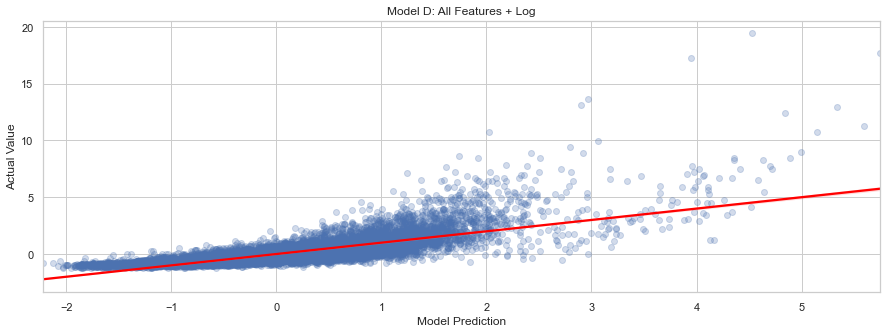

In [1136]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25},color='r')
plt.title('Model D: All Features + Log')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_D_scatterplot')

## Test Model D

In [1137]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_D].values, i) for i in range(X[result_D].shape[1])] 
list(zip(result_D, vif))

[('sqft_above_log', 3.1734686703647808),
 ('zip_A', 4.181357053003792),
 ('zip_C', 1.8100365557251938),
 ('water_1.0', 1.0392659653751086),
 ('sqft_living15_log', 2.5560865544367855),
 ('base_1.0', 2.4635663252965196),
 ('zip_B', 1.8089106532152484),
 ('age', 2.3335501530942584),
 ('bathrooms', 19.788483900684),
 ('zip_G', 1.5604406066106706),
 ('bedrooms', 16.459111969678492),
 ('zip_E', 1.4390194066239186),
 ('zip_I', 1.18117308058847),
 ('sqft_lot_log', 1.5460604428945284),
 ('cond_5.0', 1.3263757032691372),
 ('reno_1.0', 1.1599975785471839),
 ('cond_3.0', 3.8738430114061555),
 ('zip_F', 1.4511657003319696)]

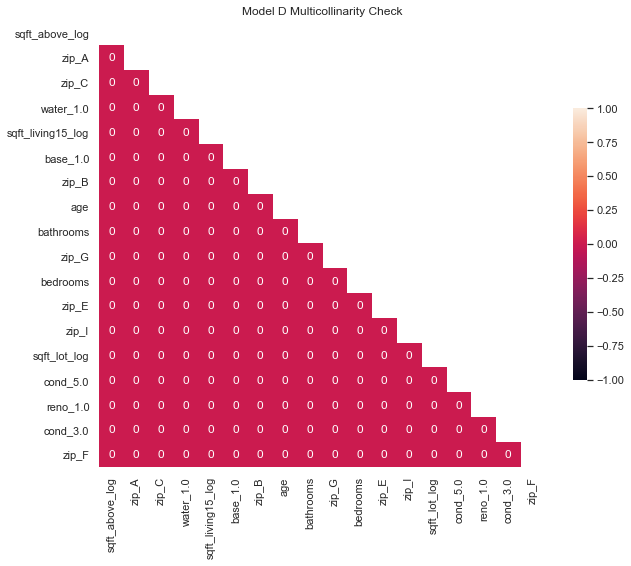

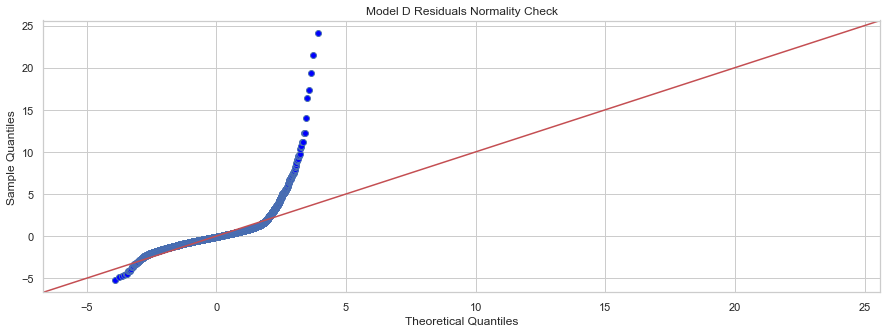

<Figure size 432x288 with 0 Axes>

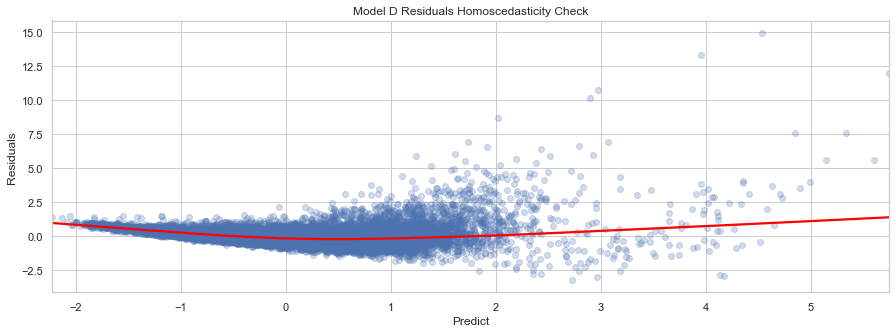

<Figure size 432x288 with 0 Axes>

In [1138]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_D].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_D].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model D Multicollinarity Check')
plt.savefig('./Data & Figures/model_D_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_D.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model D Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_D_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_D.predict(), 
            y = model_D.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25}, color = 'r')
plt.title('Model D Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_D_homoscedasticity_regplot')

In [1139]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_D.resid, model_D.model.exog)
list(zip(name, test))

[('F statistic', 1.0033659956380807), ('p-value', 0.43104232776730933)]

-0.3872608258439013


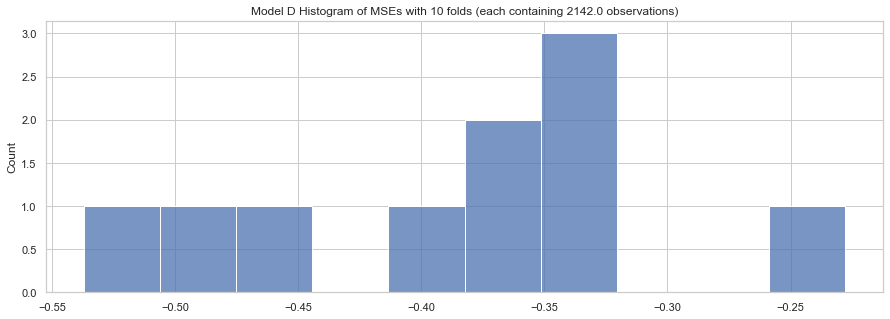

In [1140]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[result_D], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model D Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_D) / folds, 0)));
plt.savefig('./Data & Figures/model_D_cv_result_histplot')

## Validate Model D

In [1141]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[result_D], y, test_size = 0.20, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.5999984730497039
0.691206703503216


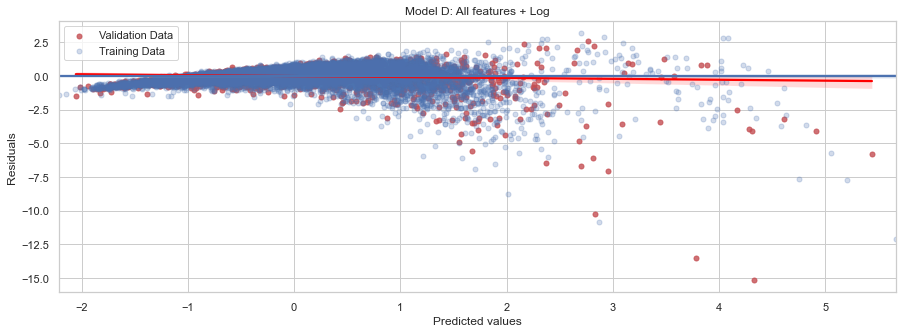

<Figure size 432x288 with 0 Axes>

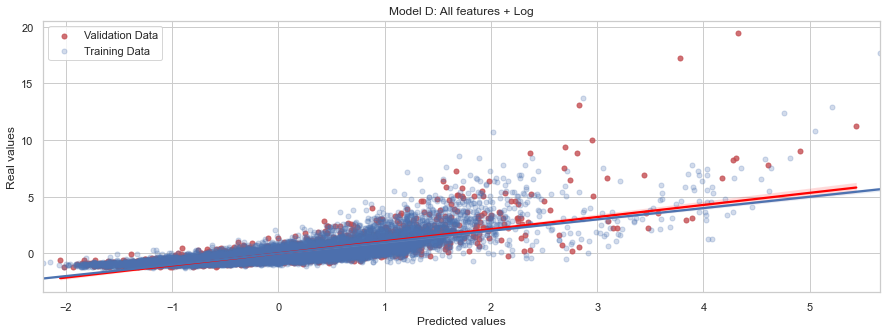

<Figure size 432x288 with 0 Axes>

In [1142]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model D: All features + Log')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_D_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model D: All features + Log')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_D_predictions_regplot')

In [1143]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 59%'

In [1144]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: 0.18109757761216522 
Train variance: 0.21309050777446614
Test bias: 0.17325903317554361 
Test variance: 0.20749552832233406


In [1145]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_D.pkl','wb'))

In [1146]:
#update summary
summary_table_1.loc[3] = ['Model D', 'All features + Log(X)', len(result_D), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'F', 'F']
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,RMSE Train,RMSE Test,Bias Train,Bias Test,Variance Train,Variance Test,Cross Validation,Multicollinearity,Normality,Homoscedasticity
0,Model A,All features,19.0,0.668177,66.236718,0.562527,0.628671,0.186644,0.179878,0.210681,0.205261,-0.336769,P,F,F
1,Model B,"All features, outliers removed, RFE",10.0,0.607514,60.932733,0.562486,0.558319,0.128394,0.122701,0.221904,0.225441,-0.318050,P,F,F
2,Model C,All features + Polynomial Regression,19.0,0.619854,66.649241,0.615233,0.624819,-1.325735,-1.331339,0.165751,0.163102,-0.386411,P,F,F
3,Model D,All features + Log(X),18.0,0.616832,59.185618,0.599998,0.691207,0.181098,0.173259,0.213091,0.207496,-0.387261,P,F,F


# MODEL E
## Log(y)

In [1147]:
preprocessed_log_E = clean[['price_log', 
                            'sqft_above', 'sqft_lot', 'sqft_living15',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

preprocessed_log_E.head()

,price_log,sqft_above,sqft_lot,sqft_living15,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,...,cond_5.0,zip_A,zip_B,zip_C,zip_E,zip_D,zip_F,zip_G,zip_H,zip_I
15937,-1.044412,-1.099527,-0.169225,-1.441766,0.955962,3,1.00,1.0,0,1,...,0,0,0,0,1,0,0,0,0,0
20963,-0.288860,-1.075393,-0.340062,-0.799934,-1.357975,2,1.75,1.5,0,1,...,0,0,0,0,0,0,0,1,0,0
7614,-0.603535,-1.292602,-0.264865,-0.697824,0.989991,3,1.00,1.0,0,1,...,0,1,0,0,0,0,0,0,0,0
3257,-0.386080,-1.147796,-0.186754,-0.085165,1.092076,2,1.00,1.0,0,1,...,1,1,0,0,0,0,0,0,0,0
16723,-0.462787,-0.230689,-0.263901,-1.164611,1.500418,5,2.00,1.5,0,0,...,0,1,0,0,0,0,0,0,0,0


In [1148]:
#specify X_train and y_train
X = preprocessed_log_E.drop(['price_log'], axis = 1)
y = preprocessed_log_E['price_log']

In [1149]:
#apply function
result_E = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_E)

Add  zip_C                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  zip_F                          with p-value 0.0
Add  zip_B                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_G                          with p-value 0.0
Add  water_1.0                      with p-value 2.45726e-232
Add  age                            with p-value 7.52417e-170
Add  zip_I                          with p-value 2.1226e-80
Add  cond_3.0                       with p-value 1.61258e-36
Add  cond_2.0                       with p-value 3.53639e-31
Add  sqft_lot                       with p-value 6.19425e-30
Add  reno_1.0                       with p-value 1.13514e-26
Add  zip_E                          with p-value 4.16859e-24
Add  bedrooms                     

## Build Model E

In [1150]:
#build model in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_E]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_E = sm.OLS(y, X_intercept).fit() 

#get summary
model_E.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     3417.
Date:                Sun, 31 Jan 2021   Prob (F-statistic):               0.00
Time:                        03:20:46   Log-Likelihood:                -15040.
No. Observations:               21420   AIC:                         3.012e+04
Df Residuals:                   21399   BIC:                         3.029e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.0889      0.024    -46.058      0.000      -1.135      -1.043
zip_C             0.9662      0.013     71.641      0.000       0.940       0.993
sqft_living15     0.2543      0.005     46.951      0.000       0.244       0.265
zip_A             1.0512      0.012     87.626      0.000       1.028       1.075
bathrooms         0.1802      0.008     22.970      0.000       0.165       0.196
zip_F            -0.1923      0.015    -12.937      0.000      -0.221      -0.163
zip_B             0.8529      0.013     66.484      0.000       0.828       0.878
sqft_above        0.4044      0.007     58.003      0.000       0.391       0.418
base_1.0          0.3318      0.009     36.881      0.000       0.314       0.349
zip_G             0.7176      0.015     48.588      0.000       0.689       0.747
water_1.0         1.2577      0.041     30.489      0.000       1.177       1.339
age               0.0992      0.005     18.896      0.000       0.089       0.110
zip_I             0.4523      0.022     20.585      0.000       0.409       0.495
cond_3.0         -0.1149      0.009    -13.469      0.000      -0.132      -0.098
cond_2.0         -0.4776      0.039    -12.227      0.000      -0.554      -0.401
sqft_lot          0.0402      0.003     11.548      0.000       0.033       0.047
reno_1.0          0.2031      0.019     10.480      0.000       0.165       0.241
zip_E             0.1604      0.016      9.883      0.000       0.129       0.192
bedrooms         -0.0392      0.005     -8.322      0.000      -0.048      -0.030
floors            0.0674      0.009      7.511      0.000       0.050       0.085
cond_5.0          0.0977      0.014      7.099      0.000       0.071       0.125
==============================================================================
Omnibus:                      623.509   Durbin-Watson:                   1.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1546.497
Skew:                          -0.094   Prob(JB):                         0.00
Kurtosis:                       4.303   Cond. No.                         56.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1151]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_E], y)

#predict yhat using our model
yhat = linreg.predict(X[result_E])
yhat

array([-1.30490848, -0.6032678 , -0.18857562, ..., -0.88652547,
       -0.36376995, -0.70524137])

In [1152]:
#get intercept
linreg.intercept_

-1.088869650705741

In [1153]:
#get coefficients and sort them
coefficients = dict(zip(X[result_E], list(linreg.coef_)))
dict(sorted(coefficients.items(), key = lambda item: item[1]))

{'cond_2.0': -0.47764536774791494,
 'zip_F': -0.19233279436592793,
 'cond_3.0': -0.11491659745738146,
 'bedrooms': -0.03920685288836552,
 'sqft_lot': 0.04024891591679721,
 'floors': 0.06738397751796499,
 'cond_5.0': 0.09769807193333306,
 'age': 0.09922007940802874,
 'zip_E': 0.1604466834482837,
 'bathrooms': 0.18015066269418498,
 'reno_1.0': 0.20314146238004496,
 'sqft_living15': 0.2542919968313241,
 'base_1.0': 0.3317796974825275,
 'sqft_above': 0.40442180310007314,
 'zip_I': 0.4523345096321353,
 'zip_G': 0.7175672187556507,
 'zip_B': 0.8528697991549893,
 'zip_C': 0.9661643535621623,
 'zip_A': 1.051241265271773,
 'water_1.0': 1.25768120385883}

**Features that decrease value of a home:**

* 'cond_2.0': -0.47764536774791494,
* 'zip_F': -0.19233279436592793,
* 'cond_3.0': -0.11491659745738146,
* 'bedrooms': -0.03920685288836552,
 
**Features that increase value of a home:**

* 'sqft_lot': 0.04024891591679721,
* 'floors': 0.06738397751796499,
* 'cond_5.0': 0.09769807193333306,
* 'age': 0.09922007940802874,
* 'zip_E': 0.1604466834482837,
* 'bathrooms': 0.18015066269418498,
* 'reno_1.0': 0.20314146238004496,
* 'sqft_living15': 0.2542919968313241,
* 'base_1.0': 0.3317796974825275,
* 'sqft_above': 0.40442180310007314,
* 'zip_I': 0.4523345096321353,
* 'zip_G': 0.7175672187556507,
* 'zip_B': 0.8528697991549893,
* 'zip_C': 0.9661643535621623,
* 'zip_A': 1.051241265271773,
* 'water_1.0': 1.25768120385883

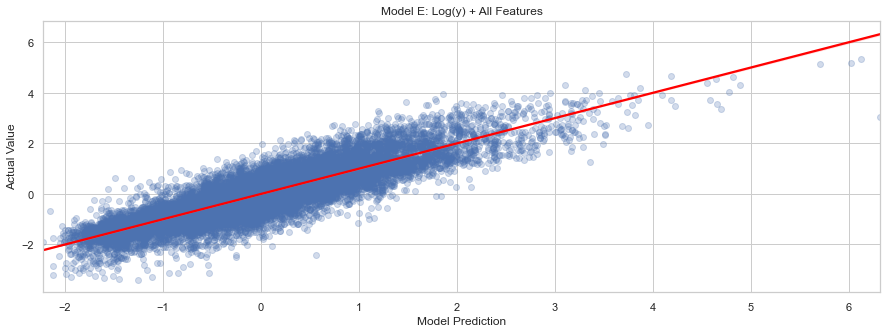

In [1154]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25},color='r')
plt.title('Model E: Log(y) + All Features')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_E_scatterplot')

## Test Model E

In [1155]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_E].values, i) for i in range(X[result_E].shape[1])] 
list(zip(result_E, vif))

[('zip_C', 1.8310948337327033),
 ('sqft_living15', 2.6321667678160554),
 ('zip_A', 4.327045799777062),
 ('bathrooms', 24.630583822087676),
 ('zip_F', 1.4592026926268789),
 ('zip_B', 1.822161744074767),
 ('sqft_above', 3.179816567338987),
 ('base_1.0', 2.7835104558763684),
 ('zip_G', 1.597354012092623),
 ('water_1.0', 1.0400452843683088),
 ('age', 2.2535175233433247),
 ('zip_I', 1.1872649337568886),
 ('cond_3.0', 4.023604547187554),
 ('cond_2.0', 1.0321601299834005),
 ('sqft_lot', 1.0729816227539866),
 ('reno_1.0', 1.1560418089432853),
 ('zip_E', 1.447624930767722),
 ('bedrooms', 17.34506129572218),
 ('floors', 15.004779616449596),
 ('cond_5.0', 1.3350310372750631)]

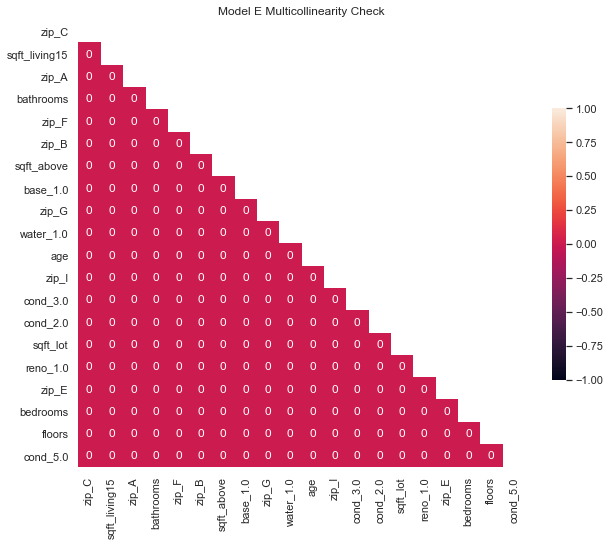

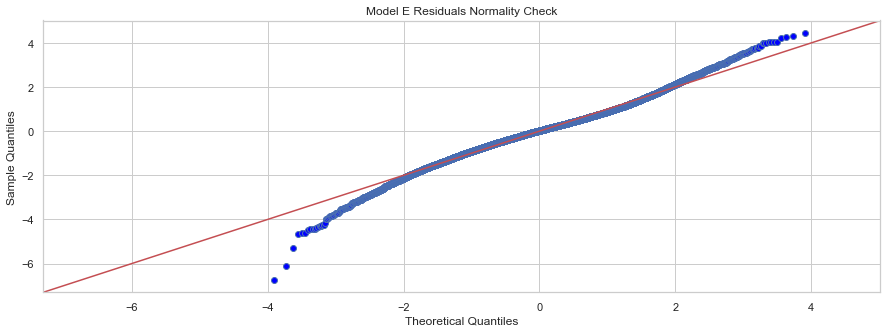

<Figure size 432x288 with 0 Axes>

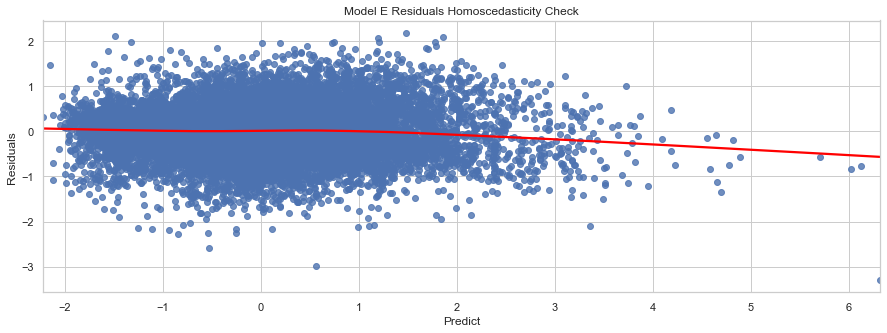

<Figure size 432x288 with 0 Axes>

In [1156]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_E].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_E].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model E Multicollinearity Check')
plt.savefig('./Data & Figures/model_E_multicollinearity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_E.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model E Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_E_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_E.predict(), 
            y = model_E.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Model E Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_E_homoscedasticity_regplot')

In [1157]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_E.resid, model_E.model.exog)
list(zip(name, test))

[('F statistic', 1.0724825083856029), ('p-value', 0.000149090153783914)]

-0.24125728193800952


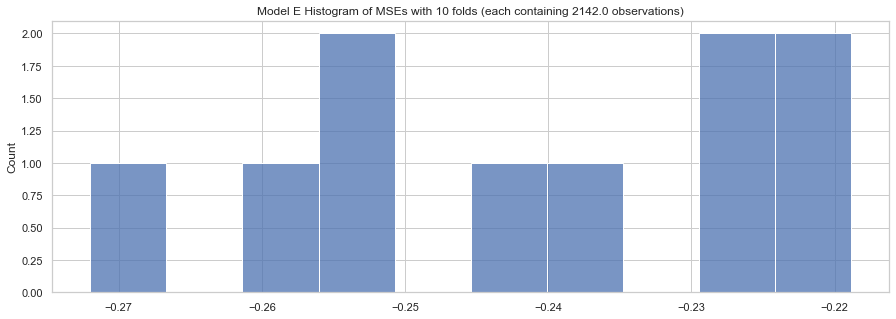

In [1158]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[result_E], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model E Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_E) / folds, 0)));
plt.savefig('./Data & Figures/model_E_cv_result_histplot')

In [1159]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[result_E], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.4905295885170489
0.4796712201647737


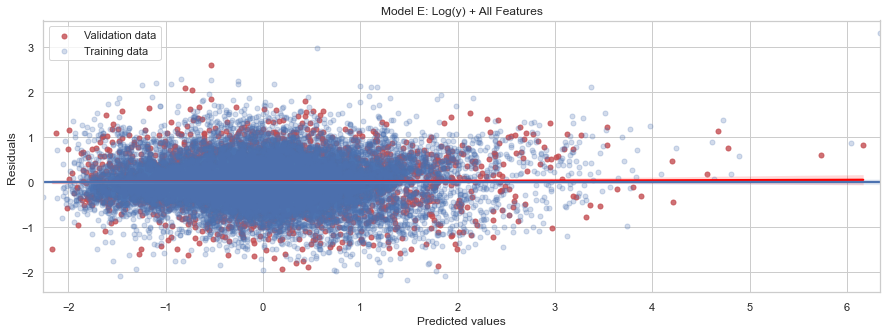

<Figure size 432x288 with 0 Axes>

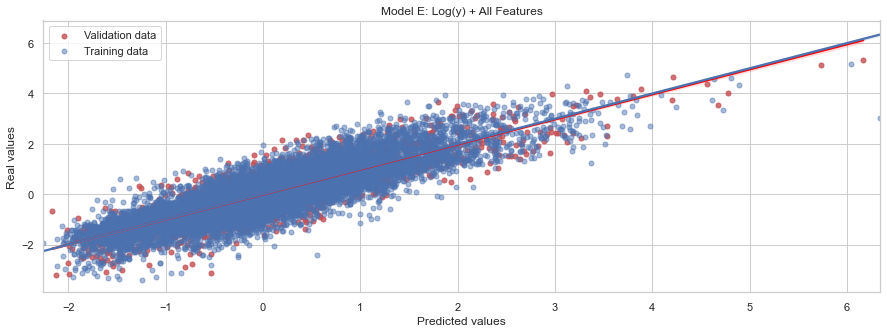

<Figure size 432x288 with 0 Axes>

In [1160]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training data')

plt.title('Model E: Log(y) + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_E_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25}, 
            color = 'r',
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws = {'s': 25,'alpha': 0.5}, fit_reg = True, label = 'Training data')

plt.title('Model E: Log(y) + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_E_predictions_regplot')

In [1161]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 77%'

In [1162]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: -0.12454426803104239 
Train variance: 0.29948311311119685
Test bias: -0.12015914721068899 
Test variance: 0.29360188277316646


In [1163]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_5.pkl','wb'))

In [1164]:
summary_table_1.loc[4] = ['Model E', 'Log(y) + All features', len(result_E), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'P', 'P']
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,RMSE Train,RMSE Test,Bias Train,Bias Test,Variance Train,Variance Test,Cross Validation,Multicollinearity,Normality,Homoscedasticity
0,Model A,All features,19.0,0.668177,66.236718,0.562527,0.628671,0.186644,0.179878,0.210681,0.205261,-0.336769,P,F,F
1,Model B,"All features, outliers removed, RFE",10.0,0.607514,60.932733,0.562486,0.558319,0.128394,0.122701,0.221904,0.225441,-0.318050,P,F,F
2,Model C,All features + Polynomial Regression,19.0,0.619854,66.649241,0.615233,0.624819,-1.325735,-1.331339,0.165751,0.163102,-0.386411,P,F,F
3,Model D,All features + Log(X),18.0,0.616832,59.185618,0.599998,0.691207,0.181098,0.173259,0.213091,0.207496,-0.387261,P,F,F
4,Model E,Log(y) + All features,20.0,0.761546,77.325163,0.490530,0.479671,-0.124544,-0.120159,0.299483,0.293602,-0.241257,P,P,P


In [1165]:
#save
summary_table_1.to_csv('./Data & Figures/summary_table_1')

# BEST FIT MODEL: MODEL E

With the linear regression, we would interpret log transformed variables as a percentage change. (https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/)

* **Only the dependent/response variable y is log-transformed:** 

Exponentiate the coefficient, subtract one from this number, and multiply by 100. This gives the percent increase (or decrease) in the response for every one-unit increase in the independent variable. Example: the coefficient is 0.198. (exp(0.198) – 1) * 100 = 21.9. For every one-unit increase in the independent variable, our dependent variable increases by about 22%.

* **Only independent/predictor variable(s) X is log-transformed:** 

Divide the coefficient by 100. This tells us that a 1% increase in the independent variable increases (or decreases) the dependent variable by (coefficient/100) units. Example: the coefficient is 0.198. 0.198/100 = 0.00198. For every 1% increase in the independent variable, our dependent variable increases by about 0.002. For x percent increase, multiply the coefficient by log(1.x). Example: For every 10% increase in the independent variable, our dependent variable increases by about 0.198 * log(1.10) = 0.02.

* **Both dependent/response variable y and independent/predictor variable(s) X are log-transformed:** 

Interpret the coefficient as the percent increase in the dependent variable for every 1% increase in the independent variable. Example: the coefficient is 0.198. For every 1% increase in the independent variable, our dependent variable increases by about 0.20%. For x percent increase, calculate 1.x to the power of the coefficient, subtract 1, and multiply by 100. Example: For every 20% increase in the independent variable, our dependent variable increases by about (1.20 0.198 – 1) * 100 = 3.7 percent.

### Interpret Model A

Since our next part (Part B) will utilize log-transformation to help us transforming a highly skewed variable into one that is more approximately normal, the result of log-transform model can really complicate the interpretation. 

Although all of these models failed the normality and homoscedasticity assumptions, let't forget about these assumptions for now and just focus on the prediction and interpretability.

Without log transformation, Model A is our best fit model with highest r2 = 0.67 and accuracy of 66%.

**Features that decreases value of the home:**

* 'cond_2.0': -0.13 =>  for every one-unit increase in cond_2.0, price decreases by 0.13 unit
* 'bedrooms': -0.11 =>  for every one-unit increase in bedrooms, price decreases by 0.11 unit
* 'zip_F': -0.08 =>  for every one-unit increase in zip_F, price decreases by 0.08 unit
* 'cond_3.0': -0.07 =>  for every one-unit increase in cond_3.0, price decreases by 0.07 unit
* 'floors': -0.05 =>  for every one-unit increase in floors, price decreases by 0.05 unit

**Features that increases value of the home:**
* 'cond_5.0': 0.08 =>  for every one-unit increase in cond_5.0, price increases by 0.08 unit
* 'zip_E': 0.13 =>  for every one-unit increase in zip_E, price increases by 0.13 unit
* 'age': 0.14 =>  for every one-unit increase in age, price increases by 0.14 unit
* 'zip_I': 0.16 =>  for every one-unit increase in zip_I, price increases by 0.16 unit
* 'sqft_living15': 0.17 =>  for every one-unit increase in sqft_living15, price increases by 0.17 unit
* 'reno_1.0': 0.17 =>  for every one-unit increase in reno_1.0, price increases by 0.21 unit
* 'bathrooms': 0.21 =>  for every one-unit increase in bathrooms, price increases by 0.13 unit
* 'base_1.0': 0.32 =>  for every one-unit increase in base_1.0, price increases by 0.32 unit
* 'zip_G': 0.34 =>  for every one-unit increase in zip_G, price increases by 0.34 unit
* 'zip_B': 0.47 =>  for every one-unit increase in zip_B, price increases by 0.47 unit
* 'sqft_above': 0.53 =>  for every one-unit increase in sqft_above, price increases by 0.53 unit
* 'zip_A': 0.73 =>  for every one-unit increase in zip_A, price increases by 0.73 unit
* 'zip_C': 0.78 =>  for every one-unit increase in zip_C, price increases by 0.78 unit
* 'water_1.0': 2.31 =>  for every one-unit increase in water_1.0, price increases by 2.13 unit

### Interpret Model E

With only log(y), Model E is our best fit model with highest r2 = 0.76 and accuracy of 77%.

**Features that decrease value of a home:**

* 'cond_2.0': -0.47 => -37.97 = for every one-unit increase in cond_2.0, price decreases by 38%
* 'zip_F': -0.19 => -17.49 = for every one-unit increase in zip_F, price decreases by 18%
* 'cond_3.0': -0.11 => -10.85 = for every one-unit increase in cond_3.0, price decreases by 11%
* 'bedrooms': -0.03 => -3.84 = for every one-unit increase in bedrooms, price decreases by 4%
 
**Features that increase value of a home:**

* 'sqft_lot': 0.04 => 4.10 = for every one-unit increase in sqft_lot, price increases by 4%
* 'floors': 0.06 => 6.97 = for every one-unit increase in floors, price increases by 7%
* 'cond_5.0': 0.09 => 10.26 = for every one-unit increase in cond_5.0, price increases by 10%
* 'age': 0.09 => 10.43 = for every one-unit increase in age, price increases by 10%
* 'zip_E': 0.16 => 17.40 = for every one-unit increase in zip_E, price increases by 17%
* 'bathrooms': 0.18 => 19.73 = for every one-unit increase in bathrooms, price increases by 20%
* 'reno_1.0': 0.20 => 22.52 = for every one-unit increase in reno_1.0, price increases by 23%
* 'sqft_living15': 0.25 => 28.95 = for every one-unit increase in sqft_living15, price increases by 29%
* 'base_1.0': 0.33 => 39.34 = for every one-unit increase in base_1.0, price increases by 40%
* 'sqft_above': 0.40 => 49.84 = for every one-unit increase in sqft_above, price increases by 50%
* 'zip_I': 0.45 => 57.19 = for every one-unit increase in zip_I, price increases by 57%
* 'zip_G': 0.71 => 104.94 = for every one-unit increase in zip_G, price increases by 105%
* 'zip_B': 0.85 => 134.63 = for every one-unit increase in zip_B, price increases by 134%
* 'zip_C': 0.96 => 162.78 = for every one-unit increase in zip_C, price increases by 163%
* 'zip_A': 1.05 => 186.12 = for every one-unit increase in zip_A, price increases by 187%
* 'water_1.0': 1.25 => 251.72 = for every one-unit increase in water_1.0, price increases by 252%

# MODEL F
## Interactions 

In [1166]:
preprocessed_log_F = clean[['price_log', 
                            'sqft_above', 'sqft_lot', 'sqft_living15',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

preprocessed_log_F.head()

,price_log,sqft_above,sqft_lot,sqft_living15,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,...,cond_5.0,zip_A,zip_B,zip_C,zip_E,zip_D,zip_F,zip_G,zip_H,zip_I
15937,-1.044412,-1.099527,-0.169225,-1.441766,0.955962,3,1.00,1.0,0,1,...,0,0,0,0,1,0,0,0,0,0
20963,-0.288860,-1.075393,-0.340062,-0.799934,-1.357975,2,1.75,1.5,0,1,...,0,0,0,0,0,0,0,1,0,0
7614,-0.603535,-1.292602,-0.264865,-0.697824,0.989991,3,1.00,1.0,0,1,...,0,1,0,0,0,0,0,0,0,0
3257,-0.386080,-1.147796,-0.186754,-0.085165,1.092076,2,1.00,1.0,0,1,...,1,1,0,0,0,0,0,0,0,0
16723,-0.462787,-0.230689,-0.263901,-1.164611,1.500418,5,2.00,1.5,0,0,...,0,1,0,0,0,0,0,0,0,0


In [1167]:
#define training variables
X = preprocessed_log_F.drop(['price_log'], axis = 1)
y = preprocessed_log_F['price_log']

In [1168]:
#get baseline model r2
from sklearn.model_selection import KFold

linreg = LinearRegression()

crossvalidation = KFold(n_splits = 10, shuffle = True, random_state =1)

baseline = np.mean(cross_val_score(linreg, X, y, scoring = 'r2', cv = crossvalidation))
baseline

0.7606072097877115

In [1169]:
from itertools import combinations

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(linreg, data, y, scoring='r2', cv = crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 10 interactions: %s' %sorted(interactions, key = lambda inter: inter[2], reverse = True)[:10])

0
50
100
150
200
Top 10 interactions: [('sqft_above', 'sqft_living15', 0.769), ('sqft_living15', 'age', 0.767), ('sqft_living15', 'floors', 0.767), ('sqft_above', 'bedrooms', 0.764), ('sqft_above', 'floors', 0.764), ('sqft_above', 'zip_A', 0.764), ('sqft_living15', 'bathrooms', 0.764), ('sqft_living15', 'cond_3.0', 0.764), ('sqft_living15', 'zip_A', 0.764), ('sqft_above', 'bathrooms', 0.763)]


In [1170]:
#check how many pairs of interaction there are
len(interactions)

139

In [1171]:
sorted(interactions, key = lambda inter: inter[2], reverse = True)[:10]

[('sqft_above', 'sqft_living15', 0.769),
 ('sqft_living15', 'age', 0.767),
 ('sqft_living15', 'floors', 0.767),
 ('sqft_above', 'bedrooms', 0.764),
 ('sqft_above', 'floors', 0.764),
 ('sqft_above', 'zip_A', 0.764),
 ('sqft_living15', 'bathrooms', 0.764),
 ('sqft_living15', 'cond_3.0', 0.764),
 ('sqft_living15', 'zip_A', 0.764),
 ('sqft_above', 'bathrooms', 0.763)]

In [1172]:
#use 10-fold cross-validation to build a model using the above interaction
regression = LinearRegression()
crossvalidation = KFold(n_splits = 10, shuffle = True, random_state = 1)
X_interactions = X.copy()

X_interactions['sqft_above * sqft_living15'] = X_interactions['sqft_above'] * X_interactions['sqft_living15']
X_interactions['sqft_living15 * age'] = X_interactions['sqft_living15'] * X_interactions['age']
X_interactions['sqft_living15 * floors'] = X_interactions['sqft_living15'] * X_interactions['floors']
X_interactions['sqft_above * bedrooms'] = X_interactions['sqft_above'] * X_interactions['bedrooms']
X_interactions['sqft_above * floors'] = X_interactions['sqft_above'] * X_interactions['floors']
X_interactions['sqft_above * zip_A'] = X_interactions['sqft_above'] * X_interactions['zip_A']
X_interactions['sqft_living15 * bathrooms'] = X_interactions['sqft_living15'] * X_interactions['bathrooms']
X_interactions['sqft_living15 * cond_3.0'] = X_interactions['sqft_living15'] * X_interactions['cond_3.0']
X_interactions['sqft_living15 * zip_A'] = X_interactions['sqft_living15'] * X_interactions['zip_A']
X_interactions['sqft_above * bathrooms'] = X_interactions['sqft_above'] * X_interactions['bathrooms']

interaction_model = np.mean(cross_val_score(regression, X_interactions, y, scoring = 'r2', cv = crossvalidation))

interaction_model

0.7736236389793466

In [1173]:
#drop p-value > 0.05
X_interactions.drop('sqft_above', axis = 1, inplace = True)

In [1174]:
#apply stepwise function
result_F = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_F)

Add  sqft_living15 * cond_3.0       with p-value 0.0
Add  sqft_above * floors            with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_F                          with p-value 0.0
Add  zip_B                          with p-value 0.0
Add  zip_G                          with p-value 0.0
Add  sqft_living15 * floors         with p-value 1.64121e-277
Add  water_1.0                      with p-value 2.13736e-218
Add  age                            with p-value 1.14141e-93
Add  bathrooms                      with p-value 1.16529e-169
Add  zip_I                          with p-value 9.53783e-96
Add  sqft_above * zip_A             with p-value 5.18185e-57
Add  cond_3.0                       with p-value 1.19418e-33
Add  sqft_above * sqft_living15     with p-value 4.52187e-31
Add  bedrooms                   

## Build Model F

In [1175]:
#create model in OLS
X_int = sm.add_constant(X_interactions[result_F])
model_F = sm.OLS(y, X_interactions[result_F]).fit()

model_F.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.747
Model:                            OLS   Adj. R-squared (uncentered):              0.747
Method:                 Least Squares   F-statistic:                              2344.
Date:                Sun, 31 Jan 2021   Prob (F-statistic):                        0.00
Time:                        03:21:34   Log-Likelihood:                         -15658.
No. Observations:               21420   AIC:                                  3.137e+04
Df Residuals:                   21393   BIC:                                  3.158e+04
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sqft_living15 * cond_3.0      -0.0402      0.009     -4.533      0.000      -0.058      -0.023
sqft_above * floors            0.2350      0.009     26.192      0.000       0.217       0.253
zip_A                          1.0184      0.013     78.228      0.000       0.993       1.044
zip_C                          0.8084      0.014     59.725      0.000       0.782       0.835
sqft_living15                  0.7322      0.019     38.812      0.000       0.695       0.769
base_1.0                       0.3152      0.009     34.467      0.000       0.297       0.333
zip_F                         -0.3330      0.015    -22.359      0.000      -0.362      -0.304
zip_B                          0.7025      0.013     55.338      0.000       0.678       0.727
zip_G                          0.6185      0.015     41.390      0.000       0.589       0.648
sqft_living15 * floors        -0.2493      0.010    -24.507      0.000      -0.269      -0.229
water_1.0                      1.1700      0.043     27.476      0.000       1.087       1.253
age                            0.0410      0.005      7.549      0.000       0.030       0.052
bathrooms                      0.0661      0.008      8.653      0.000       0.051       0.081
zip_I                          0.3750      0.022     16.693      0.000       0.331       0.419
sqft_above * zip_A             0.1465      0.010     14.289      0.000       0.126       0.167
cond_3.0                      -0.1744      0.009    -19.987      0.000      -0.191      -0.157
sqft_above * sqft_living15    -0.0693      0.004    -16.520      0.000      -0.078      -0.061
bedrooms                      -0.1580      0.004    -37.999      0.000      -0.166      -0.150
cond_2.0                      -0.5396      0.040    -13.409      0.000      -0.619      -0.461
sqft_lot                       0.0177      0.004      4.932      0.000       0.011       0.025
zip_E                          0.0131      0.016      0.802      0.423      -0.019       0.045
reno_1.0                       0.2286      0.020     11.433      0.000       0.189       0.268
cond_5.0                       0.0814      0.014      5.738      0.000       0.054       0.109
floors                        -0.1120      0.008    -13.242      0.000      -0.129      -0.095
sqft_living15 * age            0.0208      0.005      4.066      0.000       0.011       0.031
sqft_living15 * bathrooms      0.0103      0.006      1.753      0.080      -0.001       0.022
sqft_above * bedrooms          0.0373      0.004      9.786      0.000       0.030       0.045
==============================================================================
Omnibus:                      722.028   Durbin-Watson: 

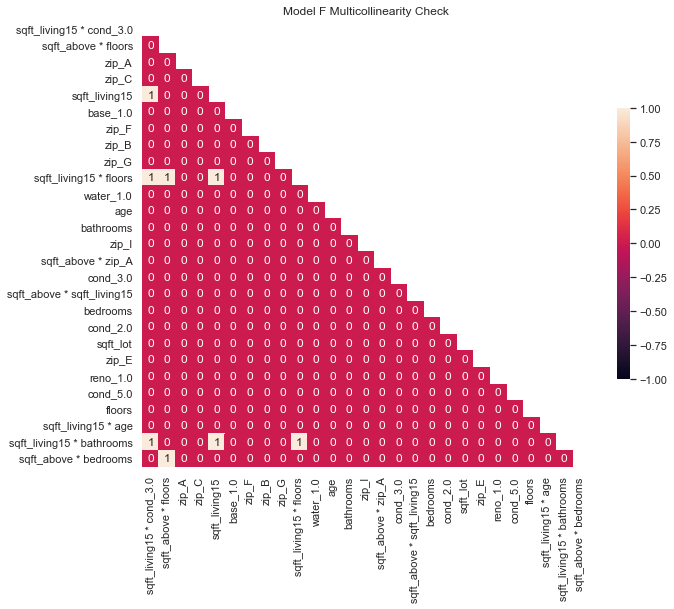

In [1176]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X_interactions[result_F].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X_interactions[result_F].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model F Multicollinearity Check')
plt.savefig('./Data & Figures/model_F_multicollinearity_check')

In [1177]:
#that have correlations over .75, but less than 1 
X_interactions_cor = X_interactions.corr().abs().stack().reset_index().sort_values(0, ascending = False)
X_interactions_cor['pairs'] = list(zip(X_interactions_cor['level_0'], X_interactions_cor['level_1']))
X_interactions_cor.set_index(['pairs'], inplace = True)
X_interactions_cor.drop(columns = ['level_0', 'level_1'], inplace = True)

#add correlation column
X_interactions_cor.columns = ['cc']

#drop duplicates
X_interactions_cor.drop_duplicates(inplace = True)

#correlations over .75, but less than 1. = multicollinarity
X_interactions_cor[(X_interactions_cor['cc'] > 0.75) & (X_interactions_cor['cc'] < 1)]

X_interactions_cor.head(11)

,cc
pairs,
"(sqft_lot, sqft_lot)",1.000000
"(sqft_above * bedrooms, sqft_above * floors)",0.961762
"(sqft_living15 * floors, sqft_living15)",0.956398
"(sqft_above * bedrooms, sqft_above * bathrooms)",0.954756
"(sqft_living15 * floors, sqft_living15 * bathrooms)",0.943060
"(sqft_above * floors, sqft_above * bathrooms)",0.941240
"(sqft_living15 * bathrooms, sqft_living15)",0.936233
"(sqft_living15 * cond_3.0, sqft_living15 * floors)",0.860944
"(sqft_living15 * cond_3.0, sqft_living15)",0.847033


In [1178]:
#drop multicollinearity
X_interactions.drop(['sqft_living15 * bathrooms', 'sqft_living15 * floors', 'sqft_living15 * cond_3.0',
                     'sqft_above * bathrooms', 'sqft_above * floors', 'sqft_above * bedrooms'], axis = 1, inplace = True)

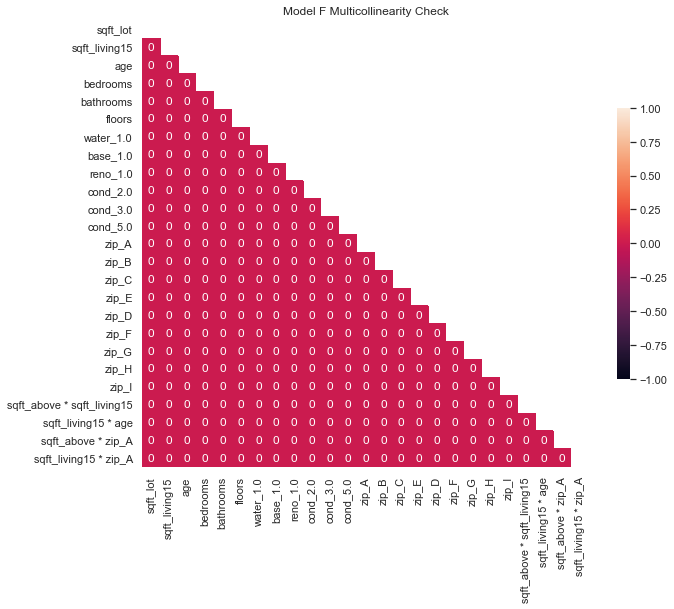

In [1179]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X_interactions.corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X_interactions.corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model F Multicollinearity Check')
plt.savefig('./Data & Figures/model_F_multicollinearity_check')

## Re-build Model F

In [1180]:
#drop p-value > 0.05
X_interactions.drop('sqft_living15', axis = 1, inplace = True)

In [1181]:
#re-apply stepwise function
result_F = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_F)

Add  sqft_above * sqft_living15     with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  sqft_living15 * zip_A          with p-value 0.0
Add  zip_F                          with p-value 0.0
Add  zip_B                          with p-value 0.0
Add  zip_G                          with p-value 0.0
Add  water_1.0                      with p-value 5.39752e-204
Add  sqft_lot                       with p-value 1.98045e-122
Add  age                            with p-value 6.91485e-88
Add  zip_I                          with p-value 3.06196e-95
Add  sqft_above * zip_A             with p-value 1.60547e-71
Add  floors                         with p-value 9.09734e-45
Add  base_1.0                       with p-value 3.78828e-67
Add  sqft_living15 * age            with p-value 1.04459e-49
Add  cond_2.0                       with p-value 8.34077e-29
Add  cond_3.0            

In [1182]:
X_int = sm.add_constant(X_interactions[result_F])
model_F = sm.OLS(y, X_interactions[result_F]).fit()

model_F.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.546
Model:                            OLS   Adj. R-squared (uncentered):              0.546
Method:                 Least Squares   F-statistic:                              1228.
Date:                Sun, 31 Jan 2021   Prob (F-statistic):                        0.00
Time:                        03:21:41   Log-Likelihood:                         -21926.
No. Observations:               21420   AIC:                                  4.389e+04
Df Residuals:                   21399   BIC:                                  4.406e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sqft_above * sqft_living15     0.0959      0.003     28.492      0.000       0.089       0.102
bathrooms                      0.2792      0.010     28.381      0.000       0.260       0.298
zip_A                          1.0664      0.018     59.830      0.000       1.031       1.101
zip_C                          0.9156      0.018     50.964      0.000       0.880       0.951
sqft_living15 * zip_A          0.4355      0.014     31.420      0.000       0.408       0.463
zip_F                         -0.6212      0.020    -31.522      0.000      -0.660      -0.583
zip_B                          0.6559      0.017     38.762      0.000       0.623       0.689
zip_G                          0.6277      0.020     31.518      0.000       0.589       0.667
water_1.0                      1.4911      0.057     26.217      0.000       1.380       1.603
sqft_lot                       0.0893      0.005     18.831      0.000       0.080       0.099
age                           -0.1250      0.007    -17.660      0.000      -0.139      -0.111
zip_I                          0.1953      0.030      6.505      0.000       0.136       0.254
sqft_above * zip_A             0.5549      0.013     41.205      0.000       0.529       0.581
floors                        -0.1551      0.011    -13.814      0.000      -0.177      -0.133
base_1.0                       0.1527      0.012     13.261      0.000       0.130       0.175
sqft_living15 * age           -0.1138      0.006    -18.437      0.000      -0.126      -0.102
cond_2.0                      -0.8507      0.054    -15.870      0.000      -0.956      -0.746
cond_3.0                      -0.2797      0.011    -25.609      0.000      -0.301      -0.258
bedrooms                      -0.2101      0.005    -38.210      0.000      -0.221      -0.199
reno_1.0                       0.3650      0.027     13.658      0.000       0.313       0.417
zip_E                         -0.3942      0.022    -18.321      0.000      -0.436      -0.352
==============================================================================
Omnibus:                      418.020   Durbin-Watson:                   1.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              860.359
Skew:                          -0.075   Prob(JB):                    1.50e-187
Kurtosis:                       3.970   Cond. No.                         56.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1183]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X_interactions[result_F], y)

#predict yhat using our model
yhat = linreg.predict(X_interactions[result_F])
yhat

array([-0.9465153 , -0.18617149, -0.36885531, ..., -1.31592337,
       -0.79175752, -0.52759395])

In [1184]:
#get intercept
linreg.intercept_

-2.16716411938679

In [1185]:
#get coefficients and sort them
coefficients = dict(zip(X_interactions[result_F], list(linreg.coef_)))
dict(sorted(coefficients.items(), key = lambda item: item[1]))

{'cond_2.0': -0.5451667084148418,
 'zip_F': -0.18103163487391905,
 'cond_3.0': -0.0944357806059413,
 'sqft_living15 * age': -0.08037500862236399,
 'bedrooms': 0.04635072853593008,
 'sqft_above * sqft_living15': 0.07232799055102751,
 'age': 0.076679709881916,
 'zip_E': 0.08644757083337865,
 'sqft_lot': 0.09709440243304134,
 'base_1.0': 0.17112036663895278,
 'reno_1.0': 0.18282174842901094,
 'sqft_above * zip_A': 0.18538195959783507,
 'floors': 0.21737249883958928,
 'bathrooms': 0.4187823455630709,
 'sqft_living15 * zip_A': 0.4197162384786732,
 'zip_I': 0.548848841867107,
 'zip_G': 0.9149168947523669,
 'zip_B': 1.025717113288617,
 'zip_A': 1.2135324977743867,
 'zip_C': 1.2309685706853601,
 'water_1.0': 1.484614770230067}

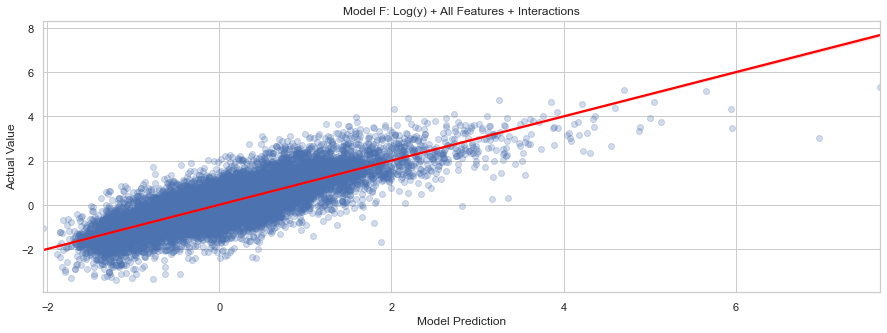

In [1186]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, scatter_kws = {'color':'b','alpha': 0.25}, line_kws = {'color': 'red'})
plt.title('Model F: Log(y) + All Features + Interactions')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_F_scatterplot')

## Re-test Model F

In [1187]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X_interactions[result_F].values, i) for i in range(X_interactions[result_F].shape[1])] 
list(zip(result_F, vif))

[('sqft_above * sqft_living15', 1.8128709739067097),
 ('bathrooms', 23.192631042272794),
 ('zip_A', 5.1541037642452485),
 ('zip_C', 1.8448088070963347),
 ('sqft_living15 * zip_A', 2.2941289825657405),
 ('zip_F', 1.4320306013164468),
 ('zip_B', 1.8222640684423694),
 ('zip_G', 1.6049050190121497),
 ('water_1.0', 1.040325732063648),
 ('sqft_lot', 1.0606267062342836),
 ('age', 2.3647914846215277),
 ('zip_I', 1.1954491599371988),
 ('sqft_above * zip_A', 2.143198673903571),
 ('floors', 15.053813829879168),
 ('base_1.0', 2.4601026281863927),
 ('sqft_living15 * age', 1.884770512329417),
 ('cond_2.0', 1.0253801517545584),
 ('cond_3.0', 3.65270387913029),
 ('bedrooms', 17.390230694850473),
 ('reno_1.0', 1.1638731070128023),
 ('zip_E', 1.4044024167529716)]

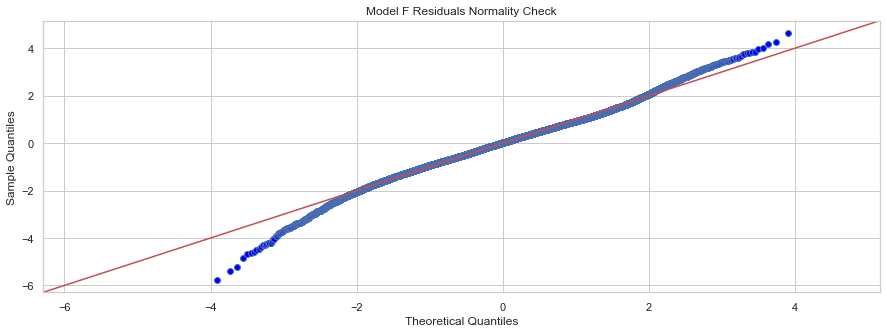

<Figure size 432x288 with 0 Axes>

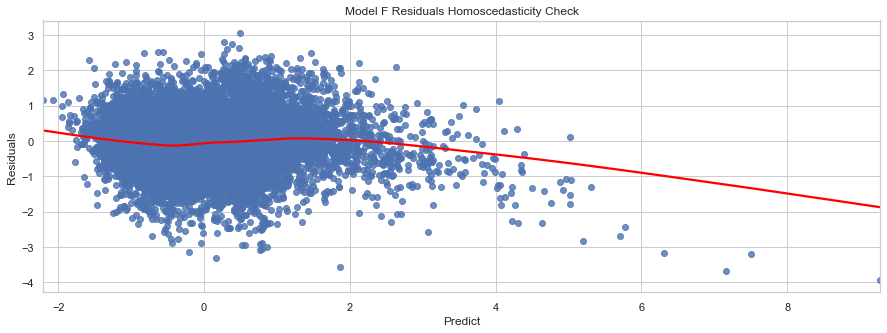

<Figure size 432x288 with 0 Axes>

In [1188]:
#recheck for normality
fig = sm.graphics.qqplot(model_F.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model F Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_F_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_F.predict(), 
            y = model_F.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Model F Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_F_homoscedasticity_regplot')

In [1189]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_F.resid, model_F.model.exog)
list(zip(name, test))

[('F statistic', 1.10217474566579), ('p-value', 2.4789157657275826e-07)]

-0.3260748180318126


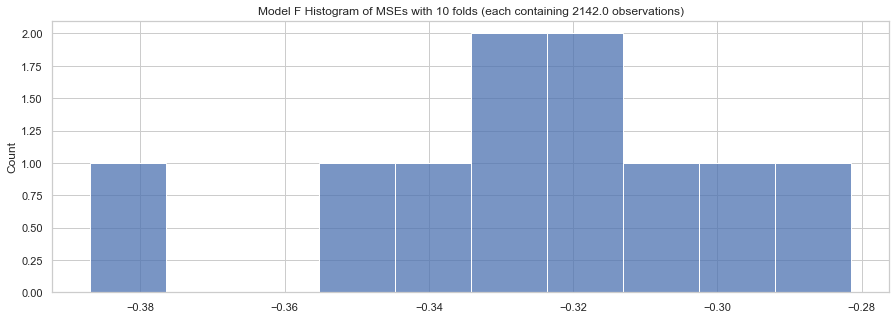

In [1190]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X_interactions[result_F], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model F Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_F) / folds, 0)));
plt.savefig('./Data & Figures/model_F_cv_result_histplot')

## Validate Model F

In [1191]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_interactions[result_F], y, test_size = 0.20, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.5700501209276141
0.5610351227268588


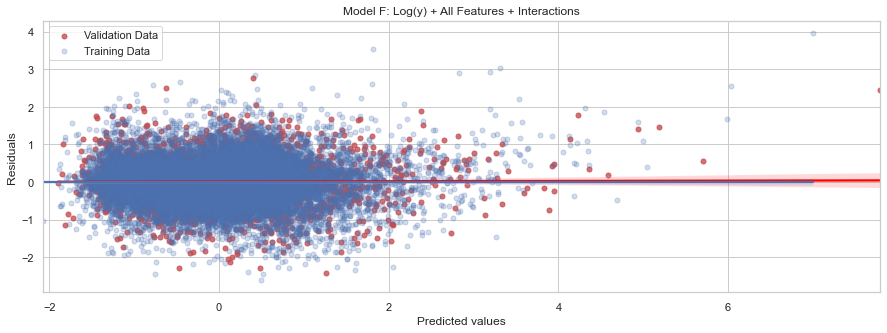

<Figure size 432x288 with 0 Axes>

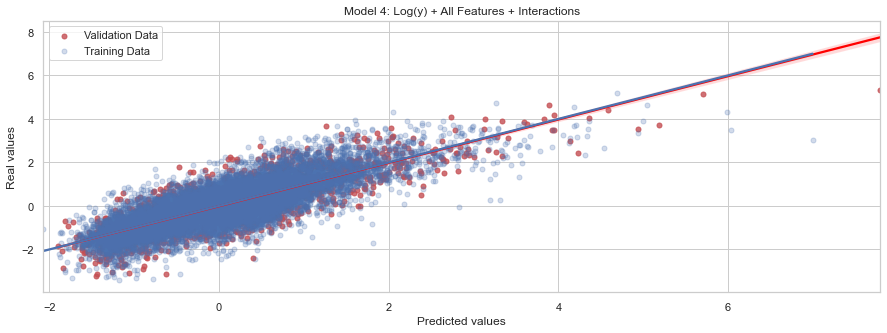

<Figure size 432x288 with 0 Axes>

In [1192]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, line_kws = {'color': 'red'}, color = 'r', fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, fit_reg = True, label = 'Training Data')


plt.title('Model F: Log(y) + All Features + Interactions')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_F_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, line_kws = {'color': 'red'}, color = 'r', fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, fit_reg = True, label = 'Training Data')

plt.title('Model 4: Log(y) + All Features + Interactions')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_F_predictions_regplot')

In [1193]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 69%'

In [1194]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: -1.0278359768937528 
Train variance: 0.34732382599066325
Test bias: -1.0246300971266837 
Test variance: 0.34146161696170996


In [1195]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_F.pkl','wb'))

In [1196]:
#update summary
summary_table_1.loc[5] = ['Model F', 'Log(y) + All features + Interactions', len(result_F) - 2, 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'P', 'P']
summary_table_1.head(10)

,Model,Description,Num Features,r2,Accuracy,RMSE Train,RMSE Test,Bias Train,Bias Test,Variance Train,Variance Test,Cross Validation,Multicollinearity,Normality,Homoscedasticity
0,Model A,All features,19.0,0.668177,66.236718,0.562527,0.628671,0.186644,0.179878,0.210681,0.205261,-0.336769,P,F,F
1,Model B,"All features, outliers removed, RFE",10.0,0.607514,60.932733,0.562486,0.558319,0.128394,0.122701,0.221904,0.225441,-0.318050,P,F,F
2,Model C,All features + Polynomial Regression,19.0,0.619854,66.649241,0.615233,0.624819,-1.325735,-1.331339,0.165751,0.163102,-0.386411,P,F,F
3,Model D,All features + Log(X),18.0,0.616832,59.185618,0.599998,0.691207,0.181098,0.173259,0.213091,0.207496,-0.387261,P,F,F
4,Model E,Log(y) + All features,20.0,0.761546,77.325163,0.490530,0.479671,-0.124544,-0.120159,0.299483,0.293602,-0.241257,P,P,P
5,Model F,Log(y) + All features + Interactions,19.0,0.677166,68.980346,0.570050,0.561035,-1.027836,-1.024630,0.347324,0.341462,-0.326075,P,P,P


In [1197]:
#save
summary_table_1.to_csv('./Data & Figures/summary_table_1')